In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
from data import FramewiseDataset, YOLODataset, Subset, collate_fn
from modules import CNNModel, YOLO
from modules.yolo import ConvBlock
from modules.yolo_utils import nms, grid_to_absolute, get_iou, get_acc
import constants as C
import nnAudio
from torchmetrics.detection.mean_ap import MeanAveragePrecision as MAP

/home/issyun/.local/lib/python3.10/site-packages/x_transformers/x_transformers.py:507: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/issyun/.local/lib/python3.10/site-packages/x_transformers/x_transformers.py:531: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [13]:
c = CNNModel(num_classes=len(C.MOTIFS))
y = YOLO(C=len(C.MOTIFS))

CQT kernels created, time used = 0.0250 seconds
CQT kernels created, time used = 0.0431 seconds


In [14]:
sum(p.numel() for p in c.parameters() if p.requires_grad)

2185037

In [5]:
sum(p.numel() for p in y.parameters() if p.requires_grad)

1965680

In [6]:
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

framewise_set = FramewiseDataset(
    Path("data/wav-22050"),
    Path("data/LeitmotifOccurrencesInstances/Instances"),
    C.TRAIN_VERSIONS,
    C.VALID_VERSIONS,
    C.TRAIN_ACTS,
    C.VALID_ACTS,
    C.MOTIFS,
    include_none_class=False,
    split="version",
    device=DEV
)

train_set = Subset(framewise_set, framewise_set.get_subset_idxs(versions=C.TRAIN_VERSIONS))
valid_set = Subset(framewise_set, framewise_set.get_subset_idxs(versions=C.VALID_VERSIONS))

rng = torch.Generator().manual_seed(1204)
train_loader = torch.utils.data.DataLoader(train_set, 
                                            batch_size=32, 
                                            shuffle=True,
                                            generator=rng, 
                                            collate_fn=collate_fn, 
                                            num_workers=0)

Loading data...


  0%|          | 0/143 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/143 [00:00<?, ?it/s]

In [7]:
batch = next(iter(train_loader))

In [15]:
batch[0].shape, batch[1].shape

(torch.Size([32, 330750]), torch.Size([32, 646, 13]))

In [17]:
c(batch[0]).shape

torch.Size([32, 646, 13])

In [20]:
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_set = YOLODataset((Path("data/wav-22050")), 
                        Path("data/LeitmotifOccurrencesInstances/"),
                        C.TRAIN_VERSIONS,
                        C.VALID_VERSIONS,
                        C.TRAIN_ACTS,
                        C.VALID_ACTS,
                        C.MOTIFS,
                        C.ANCHORS,
                        use_merged_data=True,
                        split = "version",
                        mixup_prob = 0,
                        mixup_alpha = 0,
                        pitchshift_prob=0,
                        pitchshift_semitones=0,
                        max_none_samples=0,
                        device = DEV)

train_set = Subset(base_set, base_set.get_subset_idxs(versions=C.TRAIN_VERSIONS))
valid_set = Subset(base_set, base_set.get_subset_idxs(versions=C.VALID_VERSIONS))



Loading data...


  0%|          | 0/143 [00:00<?, ?it/s]

Shuffling and truncating none samples...


In [21]:
rng = torch.Generator().manual_seed(1204)
train_loader = torch.utils.data.DataLoader(train_set, 
                                            batch_size=32, 
                                            shuffle=True,
                                            generator=rng, 
                                            collate_fn=collate_fn, 
                                            num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, 
                                            batch_size=32, 
                                            shuffle=False, 
                                            collate_fn = collate_fn,
                                            num_workers=0)
batch = next(iter(valid_loader))

In [22]:
model = YOLO(C=len(C.MOTIFS), base_hidden=24, dropout=0.4)
ckpt = torch.load("checkpoints/YOLO/merged-version-base24-do0.4-no_none_pitch0.3_best_epoch111_1.3277.pt")
model.load_state_dict(ckpt["model"])
model.to(DEV)
model.eval()

CQT kernels created, time used = 0.0567 seconds


/tmp/ipykernel_45645/3394493476.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/YOLO/merged-version-base24-do0.4-no_none_pitch0.3_best_epo

YOLO(
  (transform): CQT1992v2()
  (stack): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 24, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (1): ConvBlock(
      (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (2): ConvBlock(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (3): ConvBlock(
      (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)

In [22]:
targets = []
preds = []
with torch.inference_mode():
    for batch in tqdm(valid_loader, ascii=True):
        wav, gt = batch
        pred = model(wav.to(DEV))

        num_frames = gt.shape[1]
        pred = nms(pred, torch.tensor(C.ANCHORS).to(DEV))
        for batch_idx, p_boxes in enumerate(pred):
            targets.append(gt[batch_idx])
            framewise_pred = torch.zeros_like(gt[batch_idx])
            for p_box in p_boxes:
                conf, x, w, c = p_box
                x_start = int(round((x - w / 2) * num_frames))
                x_end = int(round((x + w / 2) * num_frames))
                framewise_pred[x_start:x_end, int(c)] += conf
            preds.append(framewise_pred)

targets = torch.cat(targets, dim=0)
preds = torch.cat(preds, dim=0)
preds /= preds.max()
                              

  0%|          | 0/7 [00:00<?, ?it/s]

646
646
646
646
646
646
646


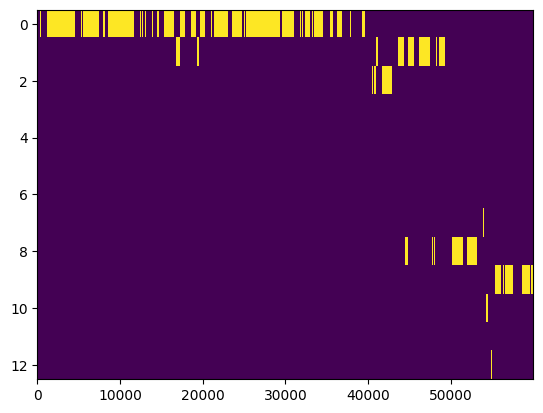

In [23]:
plt.imshow(targets[:60000, :].T, aspect="auto", interpolation="none")

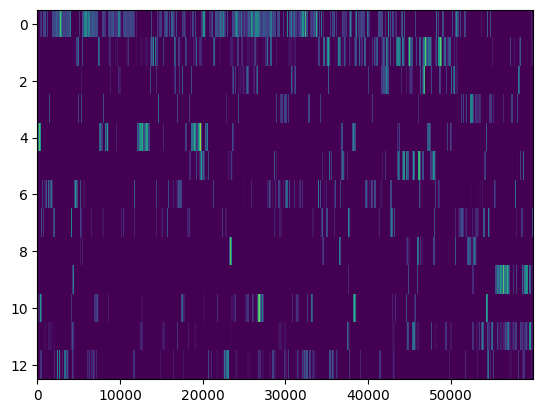

In [24]:
plt.imshow(preds[:60000, :].T, aspect="auto", interpolation="none")

In [19]:
pred = nms(pred, torch.tensor(C.ANCHORS).to(DEV))
target = gt.to("cpu")

In [20]:
from copy import deepcopy

thresholds = [x * 0.01 for x in range(10, 100, 1)]
best_f1 = [0 for _ in range(base_set.num_classes + 1)]
best_thresholds = [[0, 0] for _ in range(base_set.num_classes + 1)]
best_precision = [0 for _ in range(base_set.num_classes + 1)]
best_recall = [0 for _ in range(base_set.num_classes + 1)]

anchors = torch.tensor(C.ANCHORS).reshape(1, 3, 1, 1)
for iou_thresh in thresholds:
    for conf_thresh in thresholds:
        tp = [0 for _ in range(base_set.num_classes + 1)]
        fp = [0 for _ in range(base_set.num_classes + 1)]
        fn = [0 for _ in range(base_set.num_classes + 1)]

        t = target.clone()
        batch_size = t.shape[0]
        t[..., 1:2] = grid_to_absolute(t[..., 1:2], batched=True)
        t[..., 2:3] = t[..., 2:3] * anchors

        for i in range(batch_size):
            p = [x for x in deepcopy(pred[i]) if x[0] > conf_thresh]
            t_batch = t[i][t[i][..., 0] == 1]
            
            print(p)
            print(t_batch, t_batch.shape)

            break
        break
    break

[[0.7758538722991943, 0.23779596388339996, 0.13997973501682281, 4.0], [0.7342095971107483, 0.4156348705291748, 0.15301264822483063, 1.0], [0.7252197861671448, 0.49745824933052063, 0.15451712906360626, 4.0], [0.7042300701141357, 0.8696019649505615, 0.25061967968940735, 1.0], [0.6840110421180725, 0.32496377825737, 0.13875766098499298, 4.0], [0.6620701551437378, 0.5930905342102051, 0.1382179856300354, 4.0], [0.6555726528167725, 0.12688031792640686, 0.1611751765012741, 4.0], [0.6245642900466919, 0.677519679069519, 0.11934112757444382, 0.0], [0.5972620844841003, 0.31022894382476807, 0.2744811773300171, 4.0], [0.532241702079773, 0.07101189345121384, 0.10034965723752975, 1.0], [0.5312497019767761, 0.9447287917137146, 0.12747159600257874, 4.0], [0.5179835557937622, 0.49031615257263184, 0.207564115524292, 1.0], [0.4622105658054352, 0.7654393315315247, 0.27662602066993713, 1.0], [0.43959489464759827, 0.13661439716815948, 0.22632145881652832, 1.0], [0.4168643355369568, 0.8608190417289734, 0.13335

In [31]:
obj_mask = gt[..., 0] == 1
noobj_mask = gt[..., 0] == 0

anchors = torch.tensor(C.ANCHORS)
anchors = anchors.reshape(1, 3, 1, 1)
p = torch.cat(
    [torch.sigmoid(pred[..., 1:2]), torch.exp(pred[..., 2:3]) * anchors],
    dim=-1
) # (batch, num_anchors, S, 2)
# p = p[obj_mask]
p.shape
# p[..., 0:1] = grid_to_absolute(p[..., 0:1])

# t = torch.cat(
#     [gt[..., 1:2], gt[..., 2:3] * anchors],
#     dim=-1
# )
# t = t[obj_mask]
# t[..., 0:1] = grid_to_absolute(t[..., 0:1])

# ious = get_iou(p, t).detach()
# loss_obj = self.mse(self.sigmoid(pred[..., 0:1][obj_mask]), ious * gt[..., 0:1][obj_mask])

torch.Size([32, 3, 11, 2])

In [11]:
suppressed_boxes = nms(pred, torch.tensor(C.ANCHORS), 0.45, 0.05)

NameError: name 'pred' is not defined

In [24]:
pred = torch.tensor([0.5, 1, 2])
a = torch.tensor([1, 2, 3])
torch.exp(pred) * a

tensor([ 1.6487,  5.4366, 22.1672])

In [23]:
torch.log(torch.tensor([1.6487, 2.7183, 7.3891])) / a

tensor([0.5000, 0.5000, 0.6667])

In [53]:
def get_acc(
        suppressed_pred:list, 
        gt:torch.Tensor, 
        anchors:torch.Tensor, 
        iou_threshold=0.5,
        conf_threshold=0.1
    ):
    batch_size = gt.shape[0]
    t = torch.clone(gt)
    t[..., 1:2] = grid_to_absolute(t[..., 1:2])
    anchors = anchors.reshape(1, 3, 1, 1)
    t[..., 2:3] = t[..., 2:3] * anchors

    num_total = 0
    num_correct = 0
    for i in range(batch_size):
        if torch.sum(t[i][t[i][..., 0] == 1]) == 0:
            continue
        p = torch.tensor(suppressed_pred[i])
        for t_box in t[i][t[i][..., 0] == 1]:
            num_total += 1
            for p_box in p:
                if get_iou(t_box[1:3], p_box[1:3]) > iou_threshold and p_box[0] > conf_threshold:
                    num_correct += 1
                    break
    return num_correct / num_total
        


In [15]:
get_acc(suppressed_boxes, gt, torch.tensor(C.ANCHORS), 0.1, 0.01)

0.9555555555555556

In [13]:
model.to(DEV)

YOLO(
  (transform): CQT1992v2()
  (stack): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 24, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (1): ConvBlock(
      (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (2): ConvBlock(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (3): ConvBlock(
      (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)

In [27]:
map = MAP(
    box_format="cxcywh",
    iou_type="bbox",
    # iou_thresholds=[0.5],
    # max_detection_thresholds=[10, 50, 100]
)

anchors = torch.tensor(C.ANCHORS)

for batch in tqdm(valid_loader, ascii=True):
    wav, gt = batch
    pred = model(wav.to(DEV))
    suppressed_boxes = nms(pred, torch.tensor(C.ANCHORS).to(DEV), 0.4, 0.1)
    
    gt[..., 1:2] = grid_to_absolute(gt[..., 1:2], batched=True)
    anchors = anchors.reshape(1, 3, 1, 1)
    gt[..., 2:3] = gt[..., 2:3] * anchors

    preds = []
    target = []

    for i in range(pred.shape[0]):
        pred_boxes = torch.tensor(suppressed_boxes[i])
        gt_boxes = gt[i]
        if torch.sum(gt_boxes[gt_boxes[..., 0] == 1]) == 0: 
            print("No boxes")
            continue
        gt_boxes = gt_boxes[gt_boxes[..., 0] == 1]
        
        assert len(pred_boxes.shape) == 2 and len(gt_boxes.shape) == 2
        p_boxes = torch.cat(
            [
                pred_boxes[:, 1:2], 
                torch.ones(pred_boxes.shape[0], 1) / 2,
                pred_boxes[:, 2:3],
                torch.ones(pred_boxes.shape[0], 1)
            ], 
            dim=1
        )
        g_boxes = torch.cat(
            [
                gt_boxes[:, 1:2], 
                torch.ones(gt_boxes.shape[0], 1) / 2,
                gt_boxes[:, 2:3],
                torch.ones(gt_boxes.shape[0], 1)
            ], 
            dim=1
        )

        p = {
            "boxes": p_boxes,
            "scores": pred_boxes[:, 0],
            "labels": pred_boxes[:, 3].long()
        }

        t = {
            "boxes": g_boxes,
            "labels": gt_boxes[:, 3].long()
        }
        preds.append(p)
        target.append(t)

    map.update(preds, target)

map_val = map.compute()
print(map_val)

  0%|          | 0/59 [00:00<?, ?it/s]

{'map': tensor(0.4117), 'map_50': tensor(0.5937), 'map_75': tensor(0.4438), 'map_small': tensor(0.4117), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.4228), 'mar_10': tensor(0.5736), 'mar_100': tensor(0.5739), 'mar_small': tensor(0.5739), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)}


In [41]:
suppressed_boxes[2]

[[0.9721001386642456, 0.4289543032646179, 1.3488534688949585, 2.0],
 [0.8852840065956116, 0.31617507338523865, 0.8045249581336975, 1.0],
 [0.719464123249054, 0.15597562491893768, 0.32089710235595703, 1.0],
 [0.22131554782390594, 0.4280039072036743, 0.4885333180427551, 2.0]]

In [42]:
gt[2][gt[2][..., 0] == 1]

tensor([[1.0000, 0.1193, 0.1692, 2.0000],
        [1.0000, 0.2682, 0.1658, 2.0000],
        [1.0000, 0.3095, 0.0831, 1.0000],
        [1.0000, 0.4190, 0.1735, 2.0000],
        [1.0000, 0.5733, 0.1737, 2.0000],
        [1.0000, 0.7211, 0.1601, 2.0000],
        [1.0000, 0.1616, 0.0846, 1.0000]])

In [7]:
map = MAP(
    box_format="cxcywh",
    iou_type="bboxes",
    iou_thresholds=[0.5]
    max_detection_thresholds=[100]
)
anchors = torch.tensor(C.ANCHORS)

gt[..., 1:2] = grid_to_absolute(gt[..., 1:2])
anchors = anchors.reshape(1, 3, 1, 1)
gt[..., 2:3] = gt[..., 2:3] * anchors

i = 0

pred_boxes = torch.tensor(suppressed_boxes[i])
gt_boxes = gt[i]
gt_boxes = gt_boxes[gt_boxes[..., 0] == 1]

assert len(pred_boxes.shape) == 2 and len(gt_boxes.shape) == 2
p_boxes = torch.cat(
    [
        pred_boxes[:, 1:2], 
        torch.ones(pred_boxes.shape[0], 1),
        pred_boxes[:, 2:3],
        torch.ones(pred_boxes.shape[0], 1)
    ], 
    dim=1
)
g_boxes = torch.cat(
    [
        gt_boxes[:, 1:2], 
        torch.ones(gt_boxes.shape[0], 1),
        gt_boxes[:, 2:3],
        torch.ones(gt_boxes.shape[0], 1)
    ], 
    dim=1
)

preds = {
    "boxes": p_boxes,
    "scores": pred_boxes[:, 0],
    "labels": pred_boxes[:, 3].long()
}

target = {
    "boxes": g_boxes,
    "labels": gt_boxes[:, 3].long()
}

In [14]:
gt[0].max()

tensor(0.9091)

In [9]:
target

{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}

In [13]:
gt[0]

tensor([[[1.0000, 0.0419, 0.7171, 1.0000],
         [1.0000, 0.1659, 1.4012, 1.0000],
         [0.0000, 0.1818, 0.0000, 0.0000],
         [1.0000, 0.3213, 1.2530, 1.0000],
         [0.0000, 0.3636, 0.0000, 0.0000],
         [0.0000, 0.4545, 0.0000, 0.0000],
         [0.0000, 0.5455, 0.0000, 0.0000],
         [0.0000, 0.6364, 0.0000, 0.0000],
         [0.0000, 0.7273, 0.0000, 0.0000],
         [0.0000, 0.8182, 0.0000, 0.0000],
         [0.0000, 0.9091, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0909, 0.0000, 0.0000],
         [0.0000, 0.1818, 0.0000, 0.0000],
         [0.0000, 0.2727, 0.0000, 0.0000],
         [0.0000, 0.3636, 0.0000, 0.0000],
         [0.0000, 0.4545, 0.0000, 0.0000],
         [0.0000, 0.5455, 0.0000, 0.0000],
         [0.0000, 0.6364, 0.0000, 0.0000],
         [0.0000, 0.7273, 0.0000, 0.0000],
         [0.0000, 0.8182, 0.0000, 0.0000],
         [0.0000, 0.9091, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
       

In [22]:
gt[gt[..., 0] > 0]

tensor([[1.0000e+00, 6.6333e-01, 1.5391e+00, 1.0000e+00],
        [1.0000e+00, 6.1633e-01, 7.6182e-01, 1.0000e+00],
        [1.0000e+00, 3.1333e-01, 9.9782e-01, 1.0000e+00],
        [1.0000e+00, 5.8877e-01, 9.3991e-01, 1.0000e+00],
        [1.0000e+00, 6.7630e-01, 7.5900e-01, 1.0000e+00],
        [1.0000e+00, 8.0397e-01, 7.8720e-01, 1.0000e+00],
        [1.0000e+00, 3.0600e-01, 9.7223e-01, 1.0000e+00],
        [1.0000e+00, 7.4700e-02, 6.3579e-01, 1.0000e+00],
        [1.0000e+00, 3.7873e-01, 1.2022e+00, 1.0000e+00],
        [1.0000e+00, 7.4120e-01, 9.9132e-01, 1.0000e+00],
        [1.0000e+00, 9.3220e-01, 8.6657e-01, 1.0000e+00],
        [1.0000e+00, 2.0333e-01, 1.0629e+00, 1.0000e+00],
        [1.0000e+00, 5.2853e-01, 7.0421e-01, 1.0000e+00],
        [1.0000e+00, 8.8610e-01, 9.9432e-01, 1.0000e+00],
        [1.0000e+00, 3.8167e-01, 1.0365e+00, 1.0000e+00],
        [1.0000e+00, 1.6520e-01, 8.2342e-01, 8.0000e+00],
        [1.0000e+00, 8.7853e-01, 1.3658e+00, 8.0000e+00],
        [1.000

In [15]:
anchors = torch.tensor(C.ANCHORS).reshape(1, 3, 1, 1)

pred[..., 0:2] = torch.sigmoid(pred[..., 0:2])
pred[..., 2:3] = torch.exp(pred[..., 2:3]) * anchors
pred[..., 4:] = torch.softmax(pred[..., 4:], dim=-1)


In [38]:
torch.set_printoptions(sci_mode=False)

In [18]:
pred

tensor([[[[    0.6159,     0.5678,     1.0233,  ...,     0.1322,
               0.0190,     0.0081],
          [    0.5870,     0.1753,     0.9670,  ...,     0.0899,
               0.0123,     0.0018],
          [    0.8287,     0.5265,     1.2306,  ...,     0.0994,
               0.0003,     0.0002],
          ...,
          [    0.2229,     0.7346,     1.2409,  ...,     0.0537,
               0.0341,     0.0042],
          [    0.6045,     0.1989,     0.8460,  ...,     0.0135,
               0.0342,     0.0113],
          [    0.3859,     0.3878,     0.6945,  ...,     0.0104,
               0.0043,     0.0086]],

         [[    0.0035,     0.7113,     0.4118,  ...,     0.0434,
               0.0113,     0.0034],
          [    0.1407,     0.5386,     0.7014,  ...,     0.0143,
               0.0007,     0.0009],
          [    0.1812,     0.5139,     0.7457,  ...,     0.1055,
               0.0008,     0.0193],
          ...,
          [    0.0617,     0.5569,     0.8436,  ...,     0.

In [15]:
print(batch[0].shape)
transform = nnAudio.features.cqt.CQT1992v2().to(DEV)
cqt = transform(batch[0].to(DEV))
print(cqt.shape)
cqt = (cqt / cqt.max()).transpose(1, 2)
print(cqt.shape)



torch.Size([32, 330750])
CQT kernels created, time used = 0.0638 seconds
torch.Size([32, 84, 646])
torch.Size([32, 646, 84])


In [19]:
stack = nn.Sequential(
    ConvBlock(1, 16, (7, 7), 2, 3),
    ConvBlock(16, 32, (3, 3), 2, 1),
    ConvBlock(32, 64, (3, 3), 1, 1),
    ConvBlock(64, 32, (1, 1), 1, 0), # reduce
    ConvBlock(32, 64, (3, 3), 2, 1),
    ConvBlock(64, 128, (3, 3), (2, 1), 1),
    ConvBlock(128, 64, (1, 1), 1, 0), # reduce
    ConvBlock(64, 128, (3, 3), 2, 1),
    ConvBlock(128, 256, (3, 3), 2, 1),
    ConvBlock(256, 512, (3, 3), 1, (1, 0))
)

stack = stack.to(DEV)
print(stack(cqt.unsqueeze(1)).shape)

torch.Size([32, 512, 11, 1])


In [21]:
d = {
    "a": 1,
    "b": 2
}

d.a

AttributeError: 'dict' object has no attribute 'a'

In [3]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=lambda x: seq[x], reverse=True)

x = [5,2,1,10]

print(argsort(x))
# [2, 1, 0, 3]

[3, 0, 1, 2]


In [4]:
import math
for i in range(0, math.floor(16.4), 5):
    print(i)

0
5
10
15


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class MLP(nn.Module):
    def __init__(self, in_features, hidden, out_features):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(hidden, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
class YOLO(nn.Module):
    """
    Forward input:
        (batch, 1, 646, 128)
    
    Forward output:
        (batch, S=11, 3B + C)
    """
    def __init__(self, B=3, C=20):
        super().__init__()
        self.B = B
        self.C = C
        self.num_final_channels = (3 * self.B) + self.C
        self.stack = nn.Sequential(
            ConvBlock(1, 16, (7, 7), 2, 3),
            ConvBlock(16, 32, (3, 3), 2, 1),
            ConvBlock(32, 64, (3, 3), 1, 1),
            ConvBlock(64, 32, (1, 1), 1, 0), # reduce
            ConvBlock(32, 64, (3, 3), 2, 1),
            ConvBlock(64, 128, (3, 3), (2, 1), 1),
            ConvBlock(128, 64, (1, 1), 1, 0), # reduce
            ConvBlock(64, 128, (3, 3), 2, 1),
            ConvBlock(128, 256, (3, 3), 2, 1),
            ConvBlock(256, 512, (3, 3), 2, 1)
        )
        self.mlp = MLP(512, 512, self.num_final_channels)

    def forward(self, x):
        x = self.stack(x)
        x = x.permute(0, 2, 3, 1).squeeze(1)
        return self.mlp(x)

In [14]:
x = torch.rand((32, 1, 646, 128))
model = YOLO()
y = model(x)
print(y.shape)

torch.Size([32, 6, 2, 29])


In [21]:
p = torch.tensor([[1., 0., 0.],
                [0., 1., 0.],
                [1., 0., 0.],
                [0., 1., 0.],
                [1., 0., 0.],
                [0., 1., 0.]])
t = torch.tensor([0, 1, 0, 1, 0, 1])
print(torch.nn.functional.cross_entropy(p, t))

tensor(0.5514)


In [14]:
x = torch.tensor([[[0, 1, 1],
                   [1, 2, 2],
                   [0, 3, 3]],
                  
                  [[1, 4, 4],
                   [0, 5, 5],
                   [0, 6, 6]]])

In [17]:
mask = (x[..., 0] == 1)
mask.shape

torch.Size([2, 3])

In [20]:
x[mask]

tensor([[1, 2, 2],
        [1, 4, 4]])

In [2]:
x = torch.randn((32, 11, 29))

In [17]:
mask = (x < 0.5)

In [21]:
mask

tensor([[[False,  True, False,  ...,  True, False,  True],
         [False,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True, False, False],
         [False,  True, False,  ..., False, False,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False,  True,  True,  ...,  True, False,  True],
         [False,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ..., False,  True,  True],
         [False,  True, False,  ...,  True,  True,  True]],

        [[ True,  True, False,  ...,  True,  True,  True],
         [False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False,  True,  ...,  True,  True,  True],
         [

In [14]:
x.sum(dim=2).shape

torch.Size([32, 11])

In [7]:
[1 + 3 * i for i in range(3)]

[1, 4, 7]

In [8]:
sel = x[:, :, torch.tensor([0, 1, 2])]

In [11]:
sel = 1

In [12]:
x

tensor([[[ 8.9812e-01, -1.0457e+00,  1.0917e+00,  ..., -1.7846e-01,
           1.0912e+00, -8.9377e-01],
         [ 1.5052e+00,  1.3899e-01,  5.0746e-02,  ..., -6.8472e-01,
           8.7445e-01, -4.7279e-01],
         [ 3.9967e-01, -2.5156e+00, -1.5844e-01,  ...,  2.4894e-01,
          -5.8996e-01, -1.3239e+00],
         ...,
         [ 3.6963e-01, -5.3480e-01, -3.6831e-01,  ..., -1.6809e+00,
           1.6971e+00,  1.2848e+00],
         [ 6.9845e-01, -1.1139e+00,  1.2164e+00,  ...,  1.3995e+00,
           7.9140e-01, -8.8842e-01],
         [-2.4671e-01,  3.2656e-01, -1.6661e+00,  ..., -1.4340e+00,
          -1.0060e+00,  1.0718e-01]],

        [[ 1.6187e+00, -8.2456e-01,  4.9840e-01,  ..., -1.9688e+00,
           1.0070e+00, -8.2487e-01],
         [ 1.4921e+00, -4.0687e-01, -1.1652e+00,  ..., -1.8648e+00,
           8.0706e-01, -2.4502e-02],
         [-1.1041e+00,  1.3515e-01, -5.1555e-01,  ..., -7.3031e-01,
          -2.2094e+00, -1.7131e-01],
         ...,
         [-3.9012e-01, -1

In [2]:
base_set = FramewiseDataset(Path("data/wav-22050"), 
                      Path("data/LeitmotifOccurrencesInstances/Instances"),
                      include_none_class = False,
                      split = "act",
                      mixup_prob = 0,
                      mixup_alpha = 0,
                      device = "cuda")

train_set, valid_set, = None, None
train_set = Subset(base_set, base_set.get_subset_idxs(versions=C.TRAIN_VERSIONS))
rng = torch.Generator().manual_seed(1204)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=32, 
                                           shuffle=True, 
                                           generator=rng, 
                                           collate_fn=collate_fn,
                                           pin_memory=True,
                                           pin_memory_device="cuda")

batch = next(iter(train_loader))

Loading data...


  0%|          | 0/143 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/143 [00:00<?, ?it/s]

In [4]:
len(base_set.none_samples)

3000

In [29]:
wav = batch[0]
gt = batch[1]
wav.shape, gt.shape

(torch.Size([32, 330750]), torch.Size([32, 646, 13]))

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class MLP(nn.Module):
    """
    Input:
        (batch, S, in_features)

    Output:
        (batch, num_anchors, S, 3+C)
    """
    def __init__(self, in_features, hidden, num_anchors, C):
        super().__init__()
        self.num_anchors = num_anchors
        self.C = C
        self.fc = nn.Linear(in_features, hidden)
        self.relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(hidden, num_anchors * (3 + C))

    def forward(self, x):
        x = self.fc2(self.relu(self.fc(x)))
        x = x.reshape(x.shape[0], x.shape[1], self.num_anchors, -1)
        return x.permute(0, 2, 1, 3)

In [ ]:
# why reduce number of channels in between convolutions?
# what exactly does maxpooling do compared to conv striding?
# suitable activation function?

In [15]:
num_classes = 20
boxes_per_cell = 3
final_channels = (2 * boxes_per_cell) + num_classes
final_channels

26

In [27]:
cqt = torch.rand((32, 646, 84)).to("cuda")

block1 = ConvBlock(1, 16, (7, 7), 2, 3).to("cuda")
x = block1(cqt.unsqueeze(1))
print(x.shape)

block2 = ConvBlock(16, 32, (3, 3), 2, 1).to("cuda")
x = block2(x)
print(x.shape)

block3 = ConvBlock(32, 64, (3, 3), 1, 1).to("cuda")
x = block3(x)
print(x.shape)

block4 = ConvBlock(64, 32, (1, 1), 1, 0).to("cuda") # reduce number of channels
x = block4(x)
print(x.shape)

block5 = ConvBlock(32, 64, (3, 3), 2, 1).to("cuda")
x = block5(x)
print(x.shape)

block6 = ConvBlock(64, 128, (3, 3), (2, 1), 1).to("cuda")
x = block6(x)
print(x.shape)

block7 = ConvBlock(128, 64, (1, 1), 1, 0).to("cuda") # reduce number of channels
x = block7(x)
print(x.shape)

block8 = ConvBlock(64, 128, (3, 3), 2, 1).to("cuda")
x = block8(x)
print(x.shape)

block9 = ConvBlock(128, 256, (3, 3), 2, 1).to("cuda")
x = block9(x)
print(x.shape)

block10 = ConvBlock(256, 512, (3, 3), 1, (1, 0)).to("cuda")
x = block10(x)
print(x.shape)

x = x.permute(0, 2, 3, 1).squeeze(2)

mlp = MLP(512, 256, 3, 20).to("cuda")
x = mlp(x)
print(x.shape)

torch.Size([32, 16, 323, 42])
torch.Size([32, 32, 162, 21])
torch.Size([32, 64, 162, 21])
torch.Size([32, 32, 162, 21])
torch.Size([32, 64, 81, 11])
torch.Size([32, 128, 41, 11])
torch.Size([32, 64, 41, 11])
torch.Size([32, 128, 21, 6])
torch.Size([32, 256, 11, 3])
torch.Size([32, 512, 11, 1])
torch.Size([32, 3, 11, 23])


In [27]:
from x_transformers.x_transformers import ScaledSinusoidalEmbedding, Encoder

class BBoxModel(CNNModel):
    """
    Input: Waveform (batch, 330750)
    Output: (batch, num_classes, 2)
    """
    def __init__(self,
                 num_classes=21,
                 duration_samples = 646,
                 apply_attn=True,
                 attn_dim=64,
                 attn_depth=3,
                 attn_heads=6):
        super().__init__(num_classes=num_classes)
        self.apply_attn = apply_attn
        if self.apply_attn:
            self.pos_enc = ScaledSinusoidalEmbedding(attn_dim)
            self.encoder = Encoder(dim=attn_dim,
                                depth=attn_depth,
                                heads=attn_heads,
                                attn_dropout=0.2,
                                ff_dropout=0.2)
        self.proj = nn.Linear(attn_dim*duration_samples, num_classes*2)
    
    def forward(self, x):
        cqt = self.transform(x)
        cqt = (cqt / cqt.max()).transpose(1, 2)
        out = self.stack(cqt)
        if self.apply_attn:
            out = out + self.pos_enc(out)
            out = self.encoder(out)
        out = out.flatten(1, 2)
        bbox_pred = self.proj(out)
        bbox_pred = bbox_pred.reshape(bbox_pred.shape[0], -1, 2)
        return bbox_pred

In [28]:
model = BBoxModel(num_classes = 13).to("cuda")
model(wav.to("cuda")).shape

CQT kernels created, time used = 0.0324 seconds


torch.Size([32, 13, 2])

In [64]:
def get_boundaries(gt, none_start=-300, none_end=-200):    
    '''
    Input: Batch X Time X Classes
    Output: (Batch * Classes) X 2 (first 1, last 1)
    '''
    gt = gt.transpose(1, 2).reshape(-1, gt.shape[1]) # (batch * classes, time)
    out = torch.tensor([none_start, none_end]).repeat(gt.shape[0], 1) # (batch * classes, 2)
    for i in range(gt.shape[1]):
        out[:, 0][torch.logical_and(gt[:, i] > 0, out[:, 0] < 0)] = i
        out[:, 1][torch.logical_and(gt[:, i] > 0, out[:, 0] >= 0)] = i

    return out

In [76]:
gt_b = get_boundaries(gt)
gt_b.shape

torch.Size([416, 2])

In [92]:
pred = model(wav.to("cuda"))
pred = pred.reshape(-1, 2)

In [93]:
diou_loss(gt_b.to("cuda"), pred)

tensor(7.0812, device='cuda:0', grad_fn=<MeanBackward0>)

In [89]:
import torch

def diou_loss(pred, gt):
    pred_start, pred_end = pred[:, 0], pred[:, 1]
    gt_start, gt_end = gt[:, 0], gt[:, 1]

    intersection_start = torch.max(pred_start, gt_start)
    intersection_end = torch.min(pred_end, gt_end)
    intersection_length = torch.clamp(intersection_end - intersection_start, min=0)

    # Get union length
    pred_length = pred_end - pred_start
    gt_length = gt_end - gt_start
    union_length = pred_length + gt_length - intersection_length

    iou = intersection_length / union_length

    pred_center = (pred_start + pred_end) / 2
    gt_center = (gt_start + gt_end) / 2
    center_distance = torch.abs(pred_center - gt_center)

    # Diagonal length of the smallest enclosing box
    diagonal_length = torch.sqrt((pred_length ** 2) + (gt_length ** 2))

    diou = iou - (center_distance ** 2) / (diagonal_length ** 2)
    loss = (1 - diou).mean()
    return loss

In [8]:
import torch

def find_intervals(binary_annotations):
    intervals = []
    start = None

    # Iterate through the binary annotations
    for i, value in enumerate(binary_annotations):
        # If the value is 1 and start is None, set start to the current index
        if value == 1 and start is None:
            start = i
        # If the value is 0 and start is not None, add the interval to the list and reset start
        elif value == 0 and start is not None:
            intervals.append((start, i - 1))
            start = None

    # If a sequence of 1s continues until the end of the array, add it as well
    if start is not None:
        intervals.append((start, len(binary_annotations) - 1))

    return intervals

# Example usage:
binary_annotations = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1, 0])
intervals = find_intervals(binary_annotations)
print("Intervals:", intervals)

# Retrieve the first interval
start, end = intervals[0]
print("Start position:", start)
print("End position:", end)

Intervals: [(4, 7)]
Start position: 4
End position: 7


# Check memory size of variable

In [15]:
import sys
import math

# Define the variable
my_variable = [1, 2, 3, 4, 5]

# Get the memory size of the variable
memory_size = sys.getsizeof(cqt_mag)

# Convert the memory size to a human-readable format
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

human_readable_size = convert_size(memory_size)

# Print the human-readable memory size
print(human_readable_size)


128.48 MB


# Motif ground truth plot

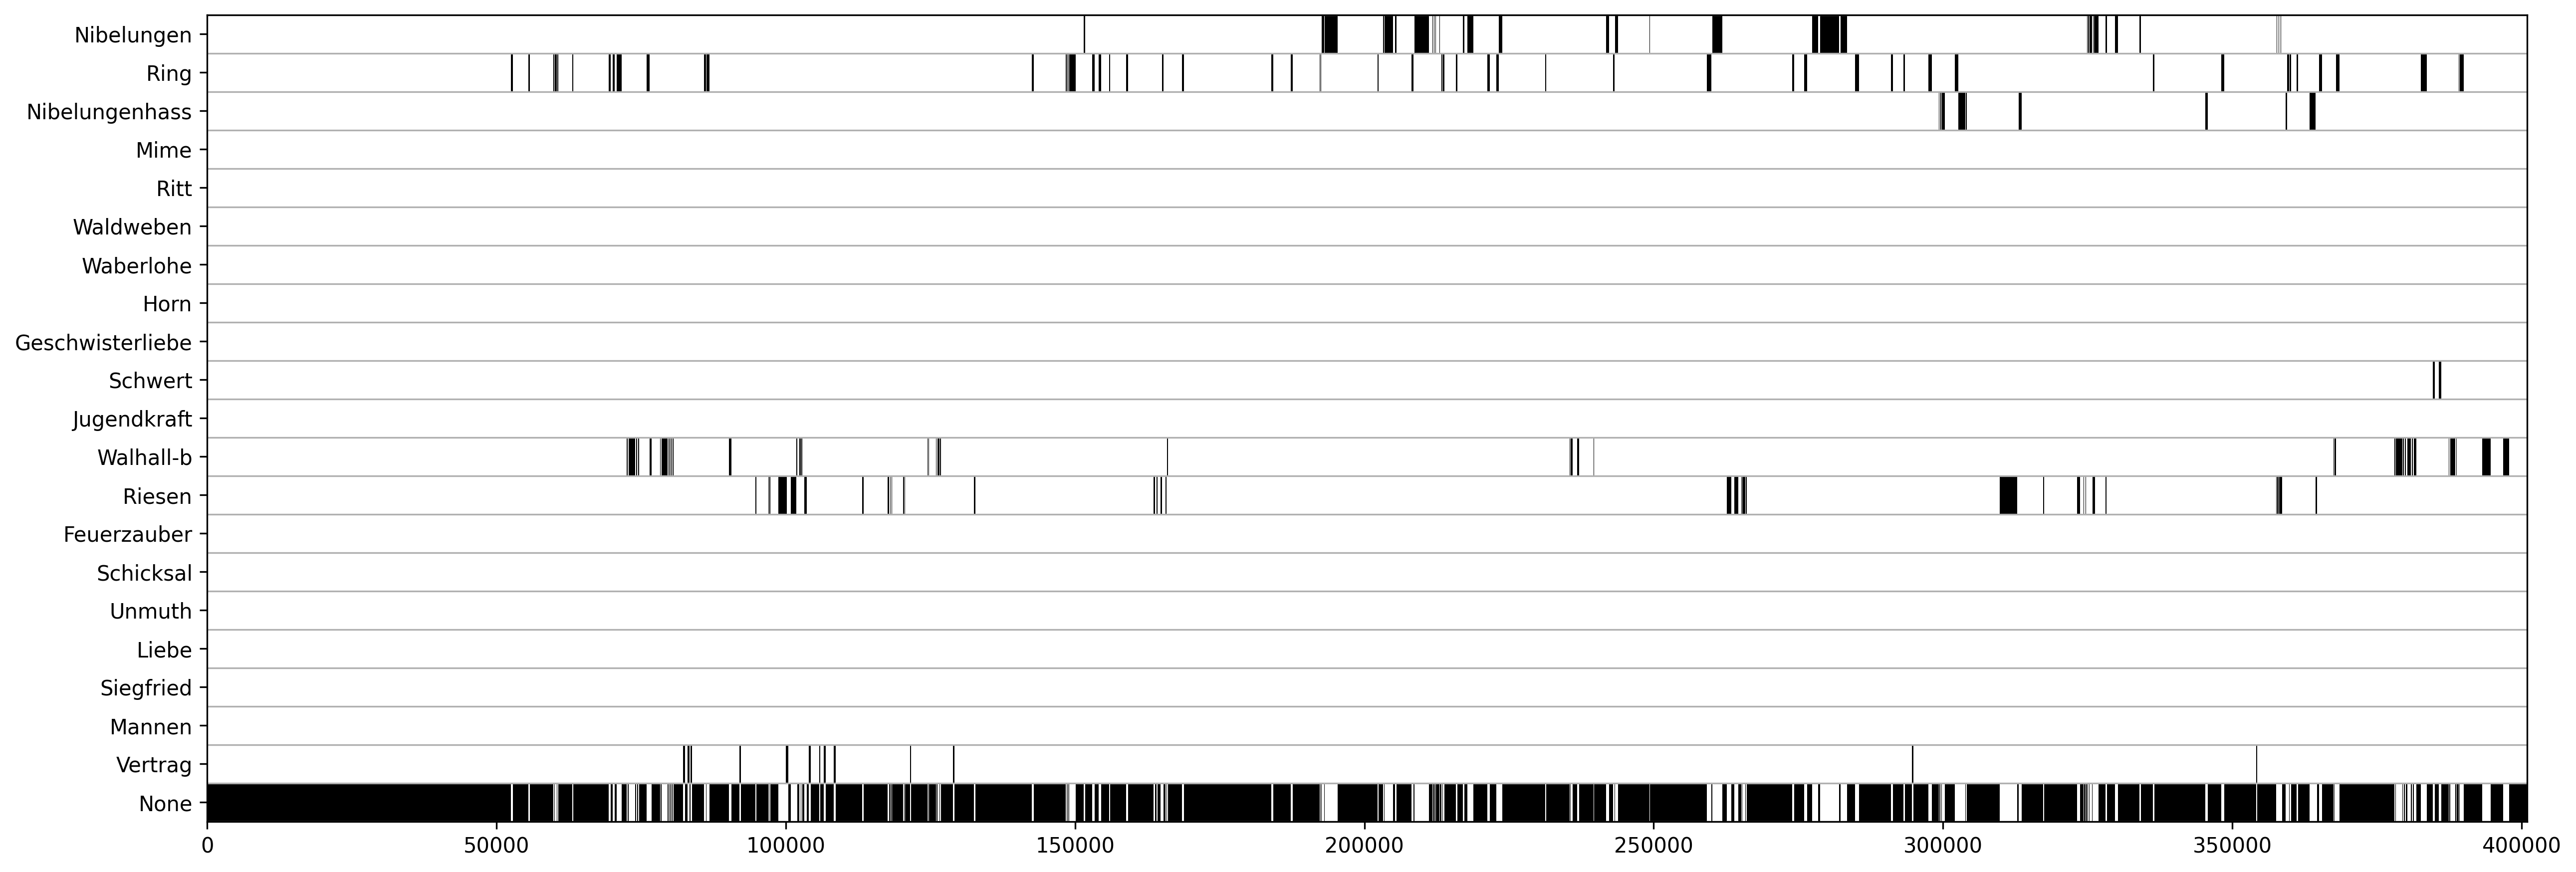

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 7), dpi=300)
im = ax.imshow(dataset.instances_gt["Fu_A"].T, origin="upper", aspect="auto", interpolation="none", cmap="binary")
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.set_yticks(range(21))
ax.set_yticklabels(idx2motif + ["None"])
ax.tick_params(axis="y", which="minor", length=0)
plt.grid(axis="y", which="minor")
plt.show()

# inference test

In [2]:
from dataset import OTFDataset
from pathlib import Path

dataset = OTFDataset(Path("data/wav-22050"),
                     Path("data/LeitmotifOccurrencesInstances/Instances"),
                     Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing"))

CQT kernels created, time used = 0.0500 seconds
Loading data...


  0%|          | 0/176 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/176 [00:00<?, ?it/s]

In [2]:
gt = torch.load('leitmotif_gt_Kr_A.pt')
pred = torch.load('leitmotif_pred_Kr_A.pt')
pred_medfilt = torch.load('leitmotif_pred_Kr_A_medfilt.pt')
gt_maxed = torch.load('leitmotif_gt_maxed_Kr_A.pt')
pred_maxed = torch.load('leitmotif_pred_maxed_Kr_A.pt')

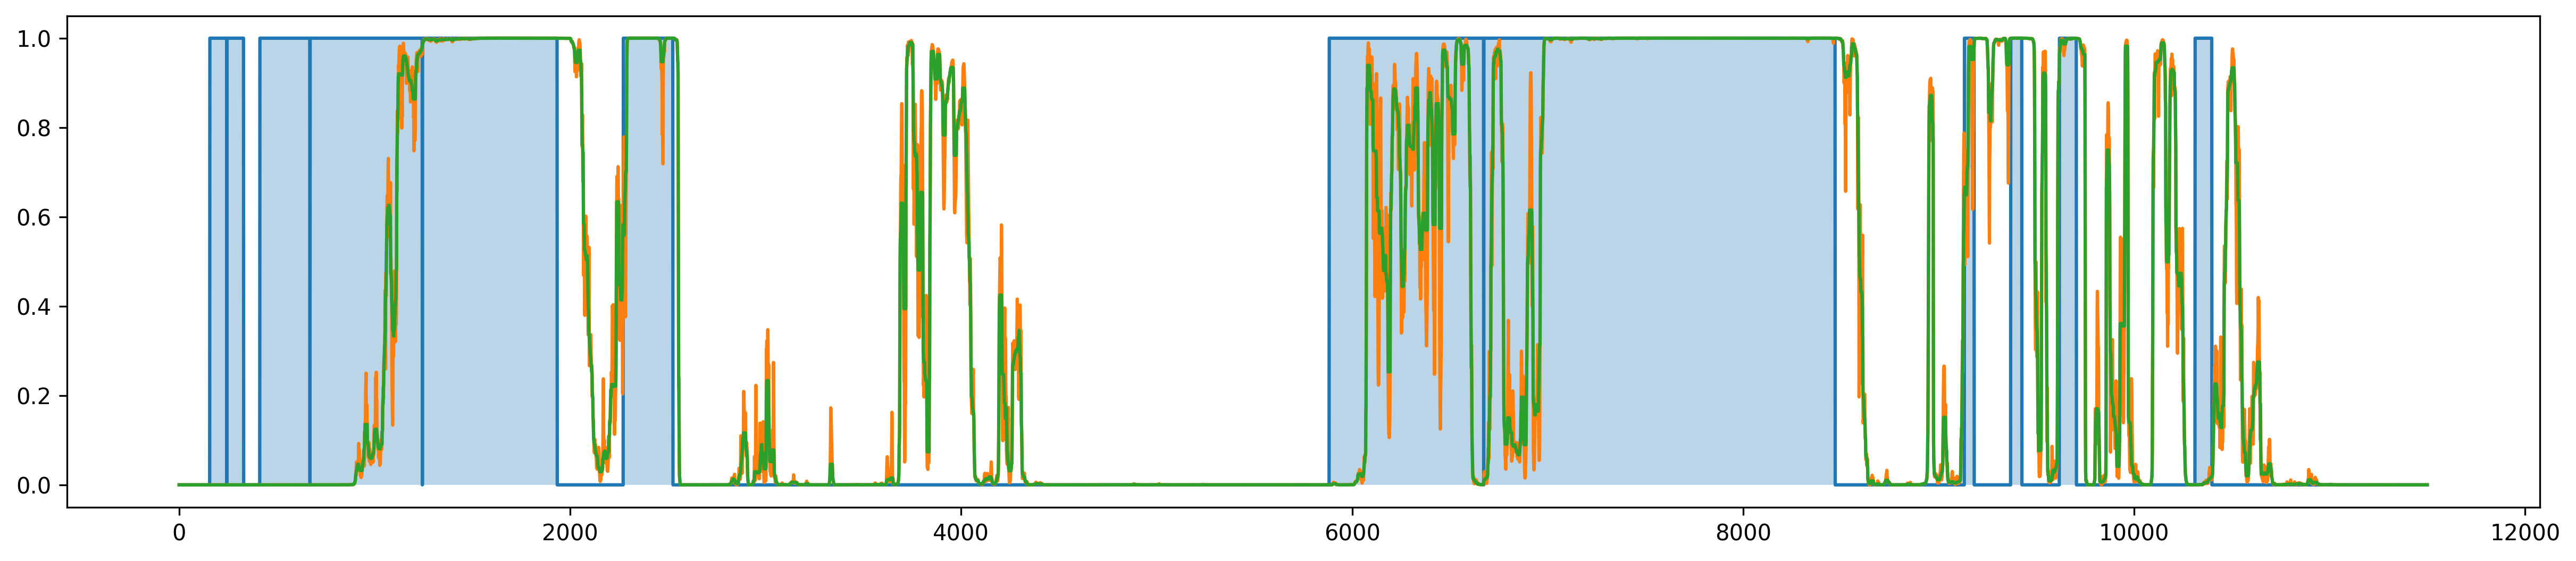

In [33]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt[186500:198000, 0])
ax.fill_between([x for x in range(11500)], gt[186500:198000, 0], alpha=0.3)
ax.plot(pred[186500:198000, 0])
ax.plot(pred_medfilt[186500:198000, 0])


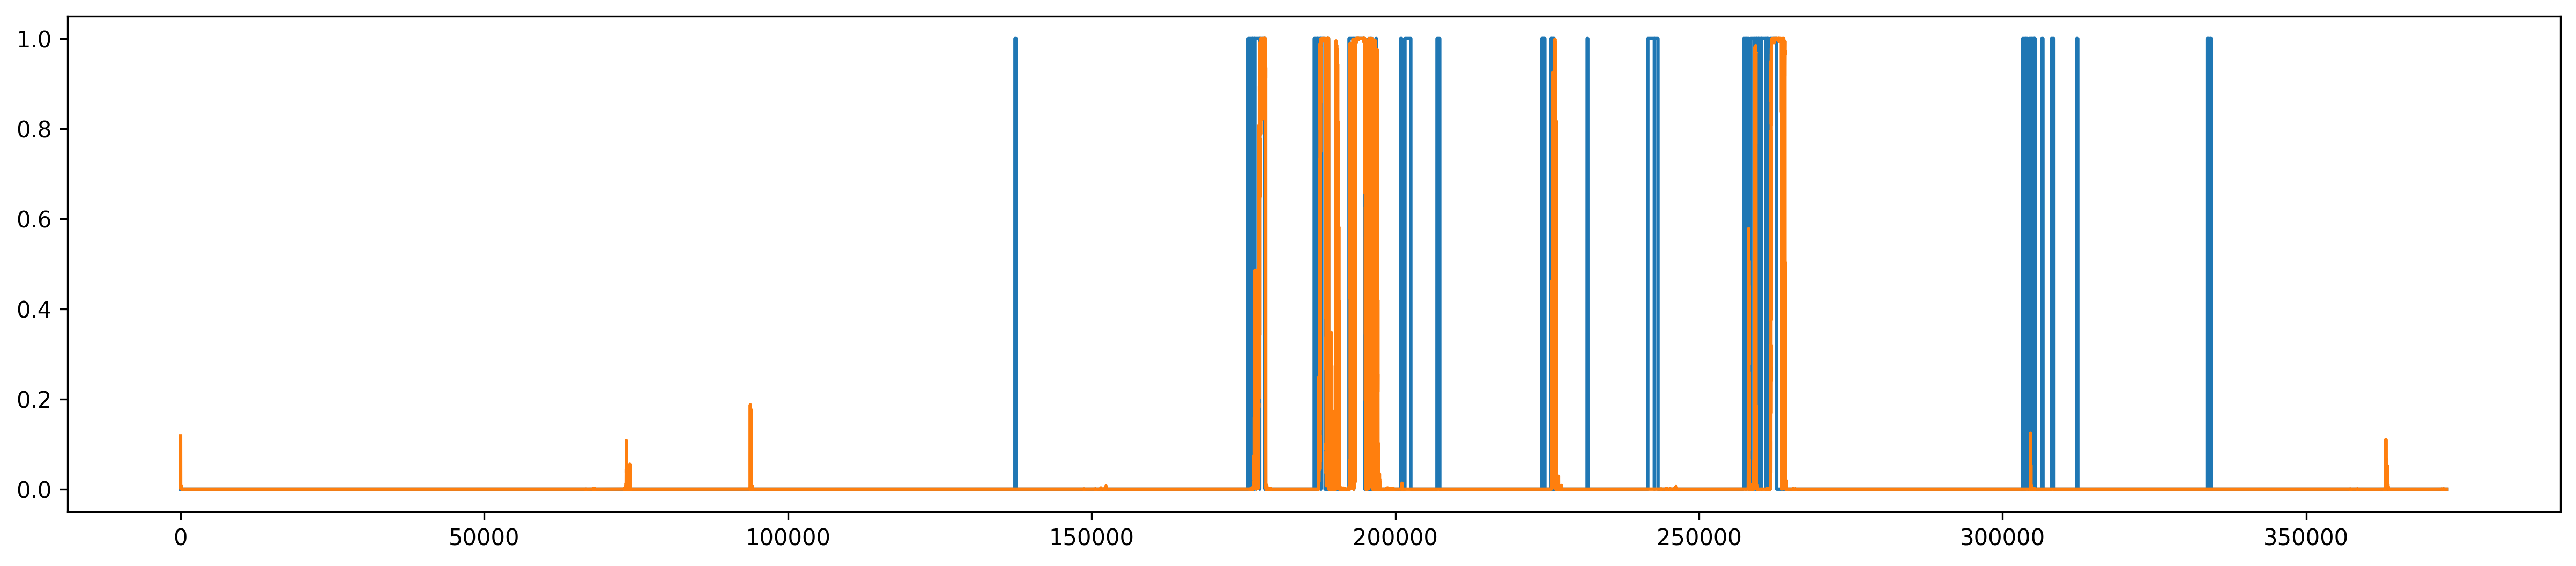

In [35]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt[:, 0])
ax.plot(pred[:, 0])

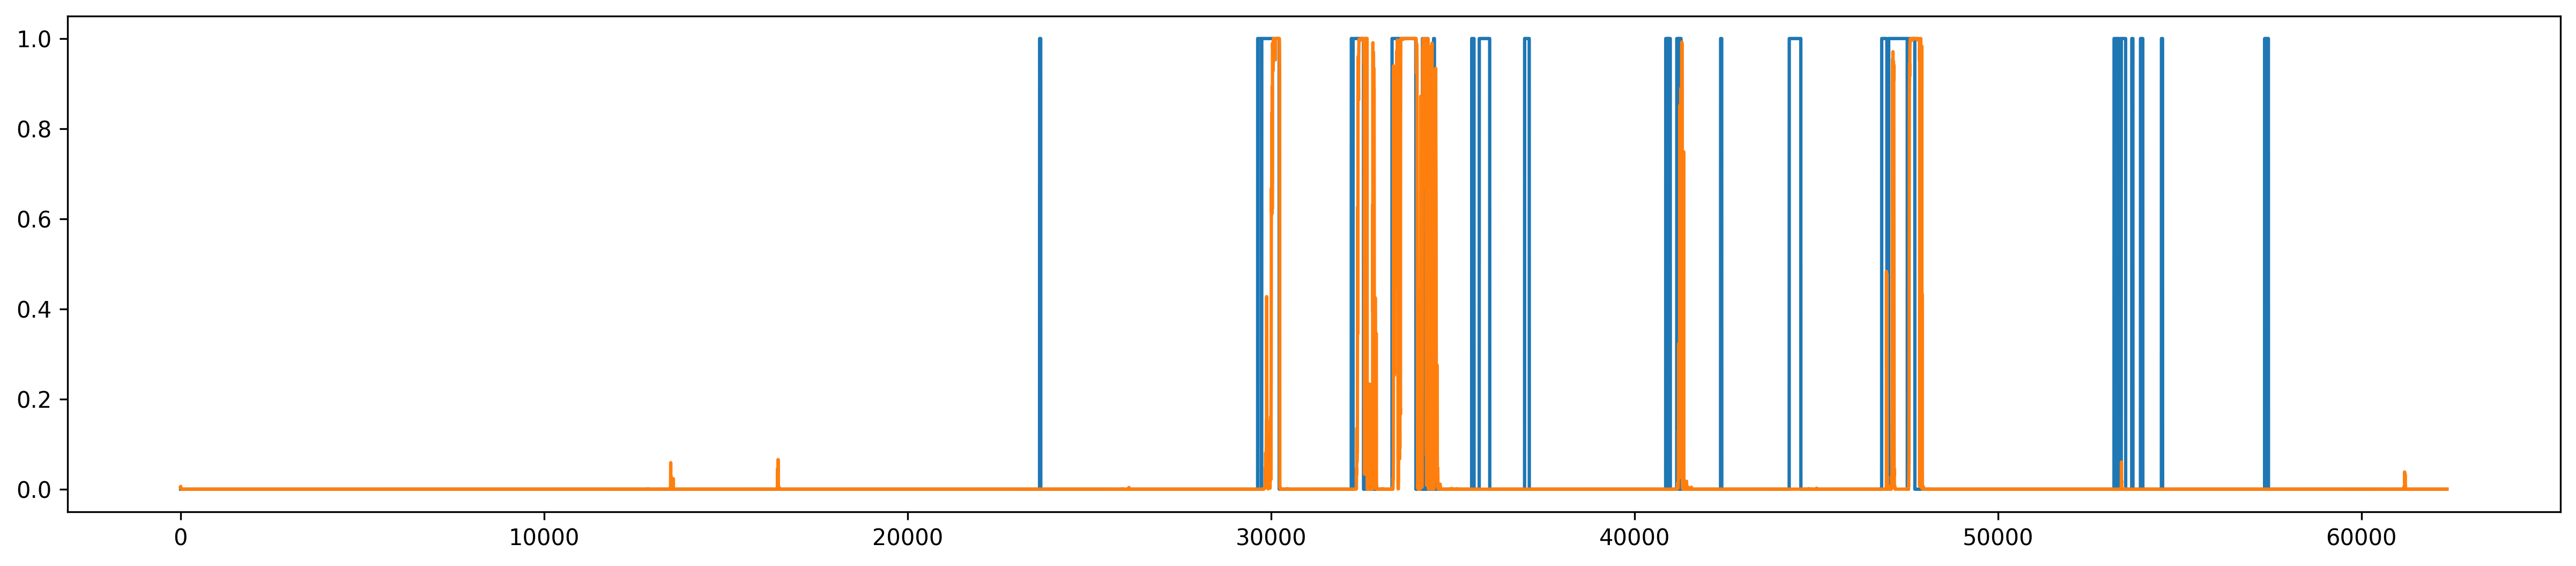

In [34]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt_maxed[:, 0])
ax.plot(pred_maxed[:, 0])


# inference plot

### Failed RNN inference

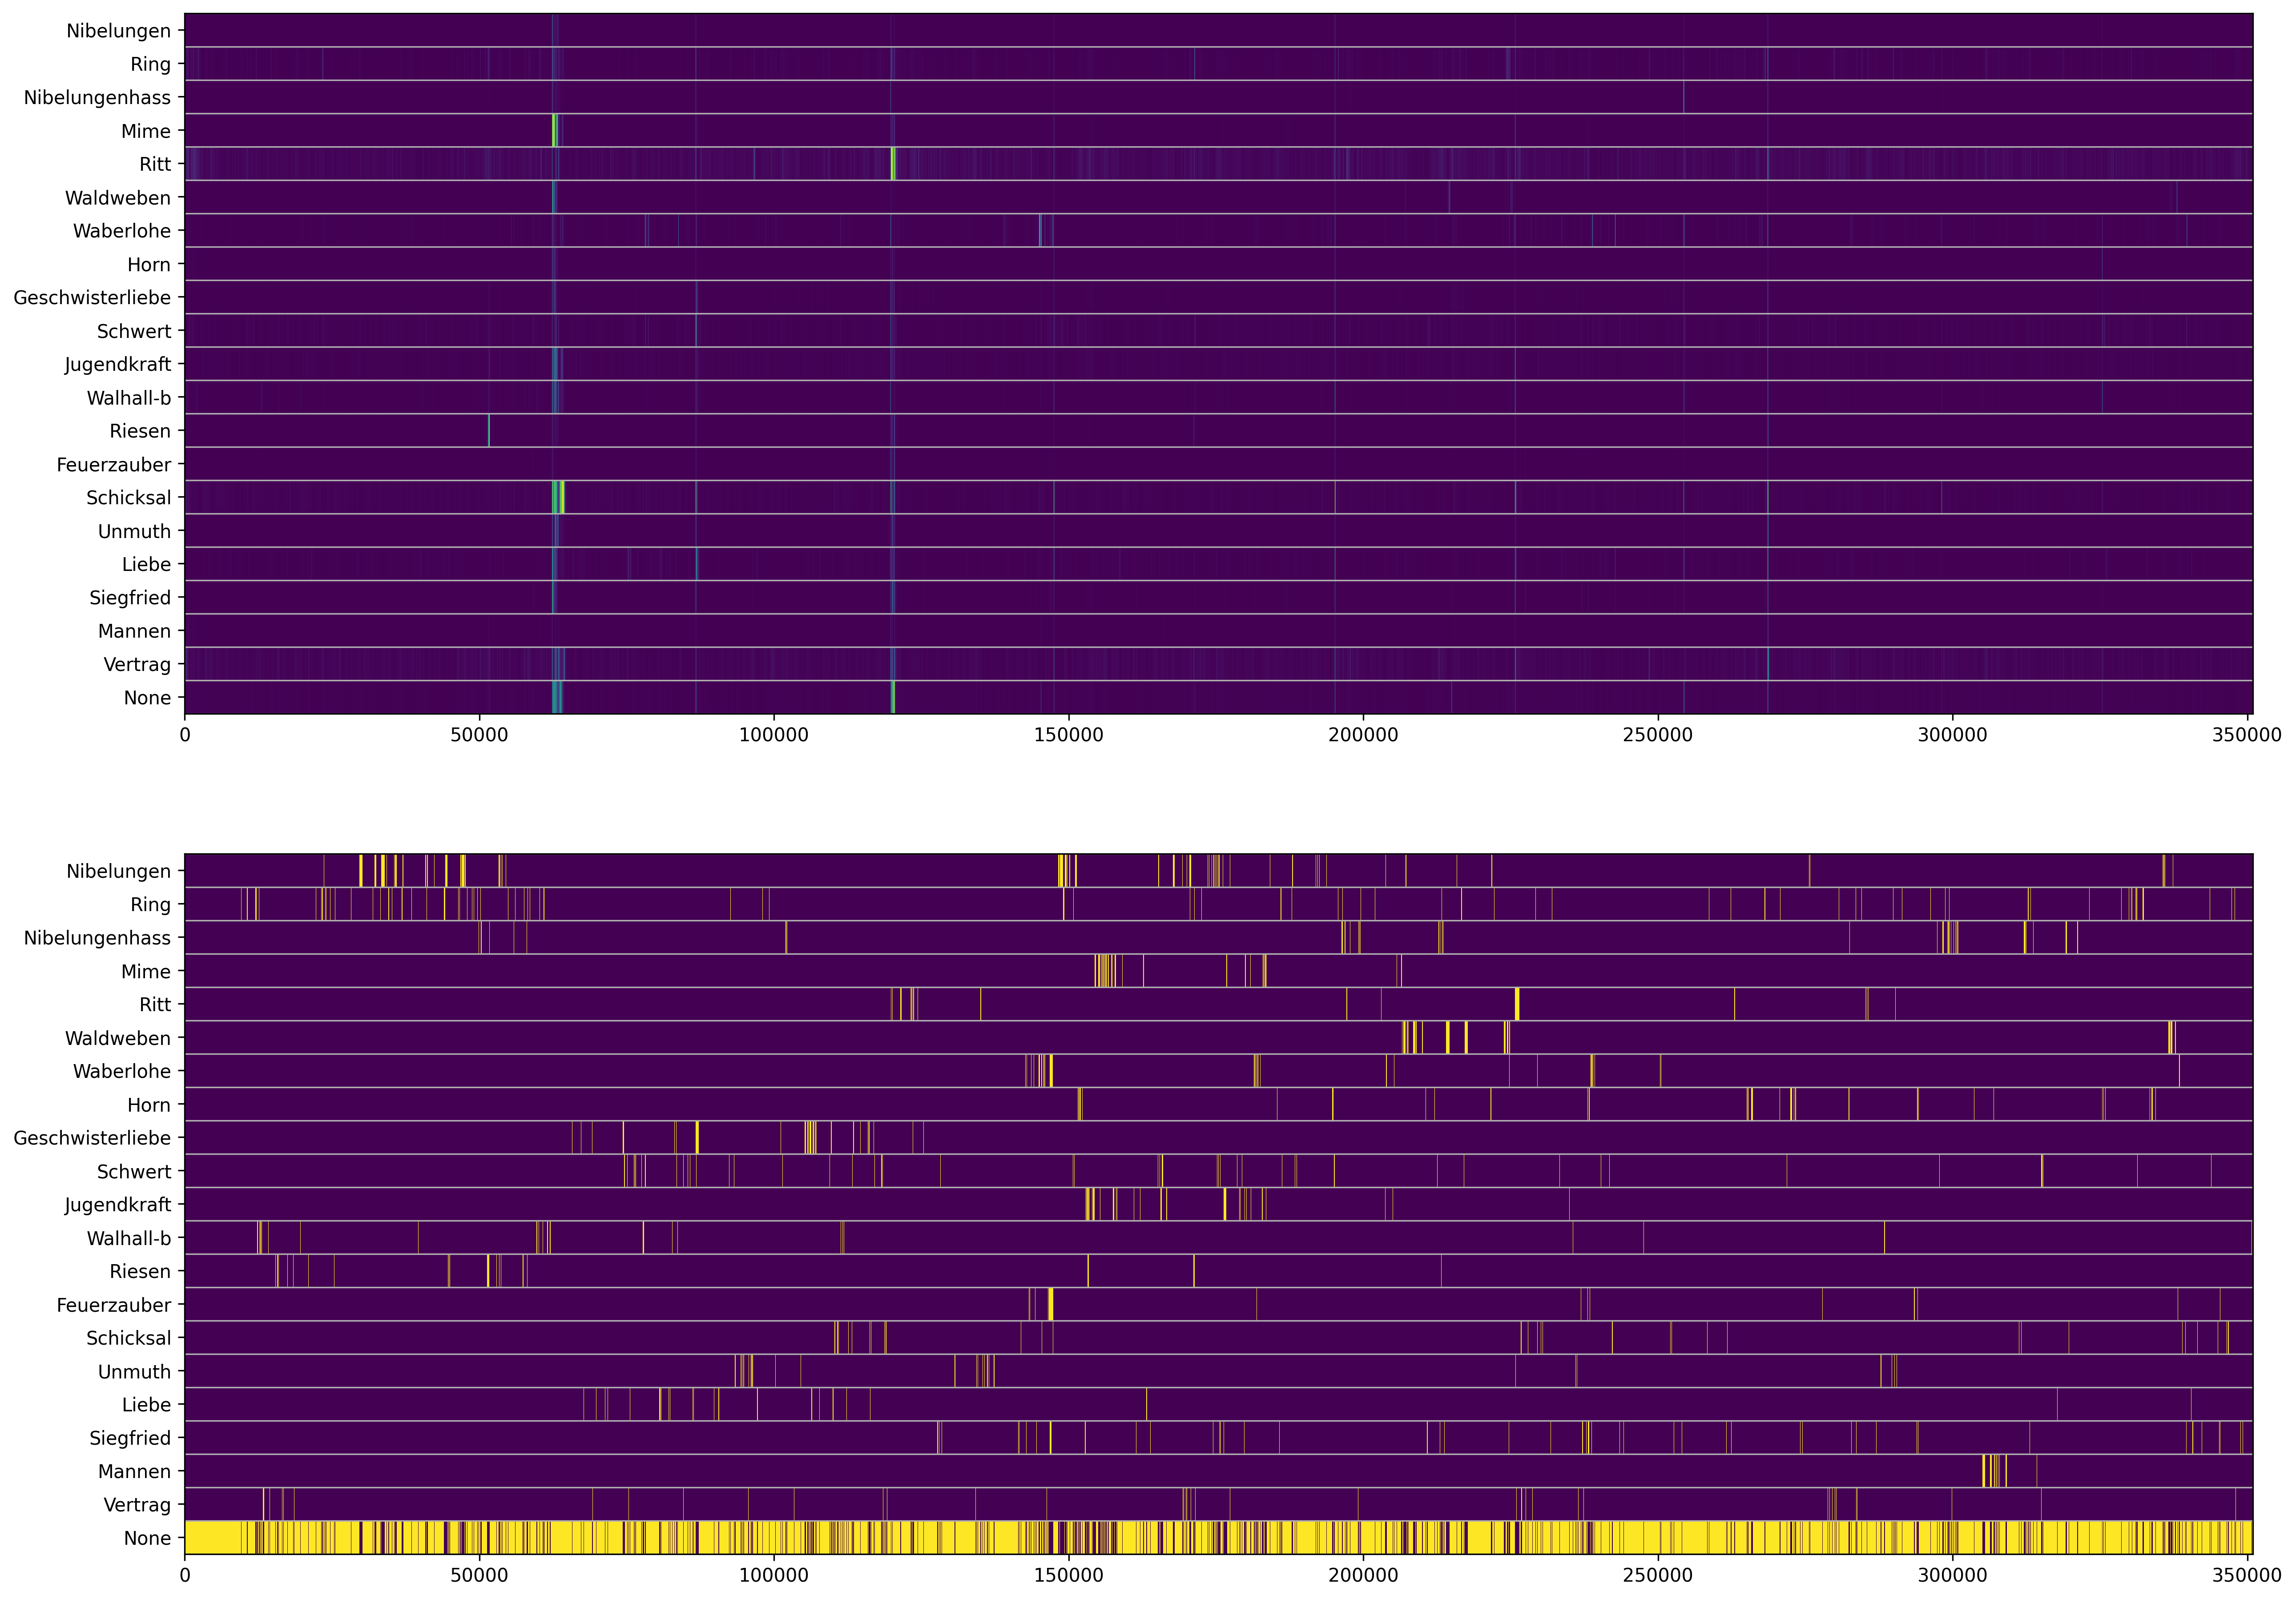

In [18]:
leitmotif_preds = torch.load("pred.pt")
leitmotif_gts = torch.load("gt.pt")

# pool = torch.nn.MaxPool1d(kernel_size=16, stride=1, padding=8)
# leitmotif_preds = pool(leitmotif_preds.T).T
# leitmotif_gts = pool(leitmotif_gts.T).T

fig, ax = plt.subplots(nrows=2, figsize=(20, 15), dpi=300)
im = ax[0].imshow(leitmotif_preds.T, origin="upper", aspect="auto", interpolation="none")
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[0].set_yticks(range(21))
ax[0].set_yticklabels(idx2motif + ["None"])
ax[0].tick_params(axis="y", which="minor", length=0)

im = ax[1].imshow(leitmotif_gts.T, origin="upper", aspect="auto", interpolation="none")
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[1].set_yticks(range(21))
ax[1].set_yticklabels(idx2motif + ["None"])
ax[1].tick_params(axis="y", which="minor", length=0)

ax[0].grid(axis="y", which="minor")
ax[1].grid(axis="y", which="minor")

plt.show()

### RNN with merged valid loader

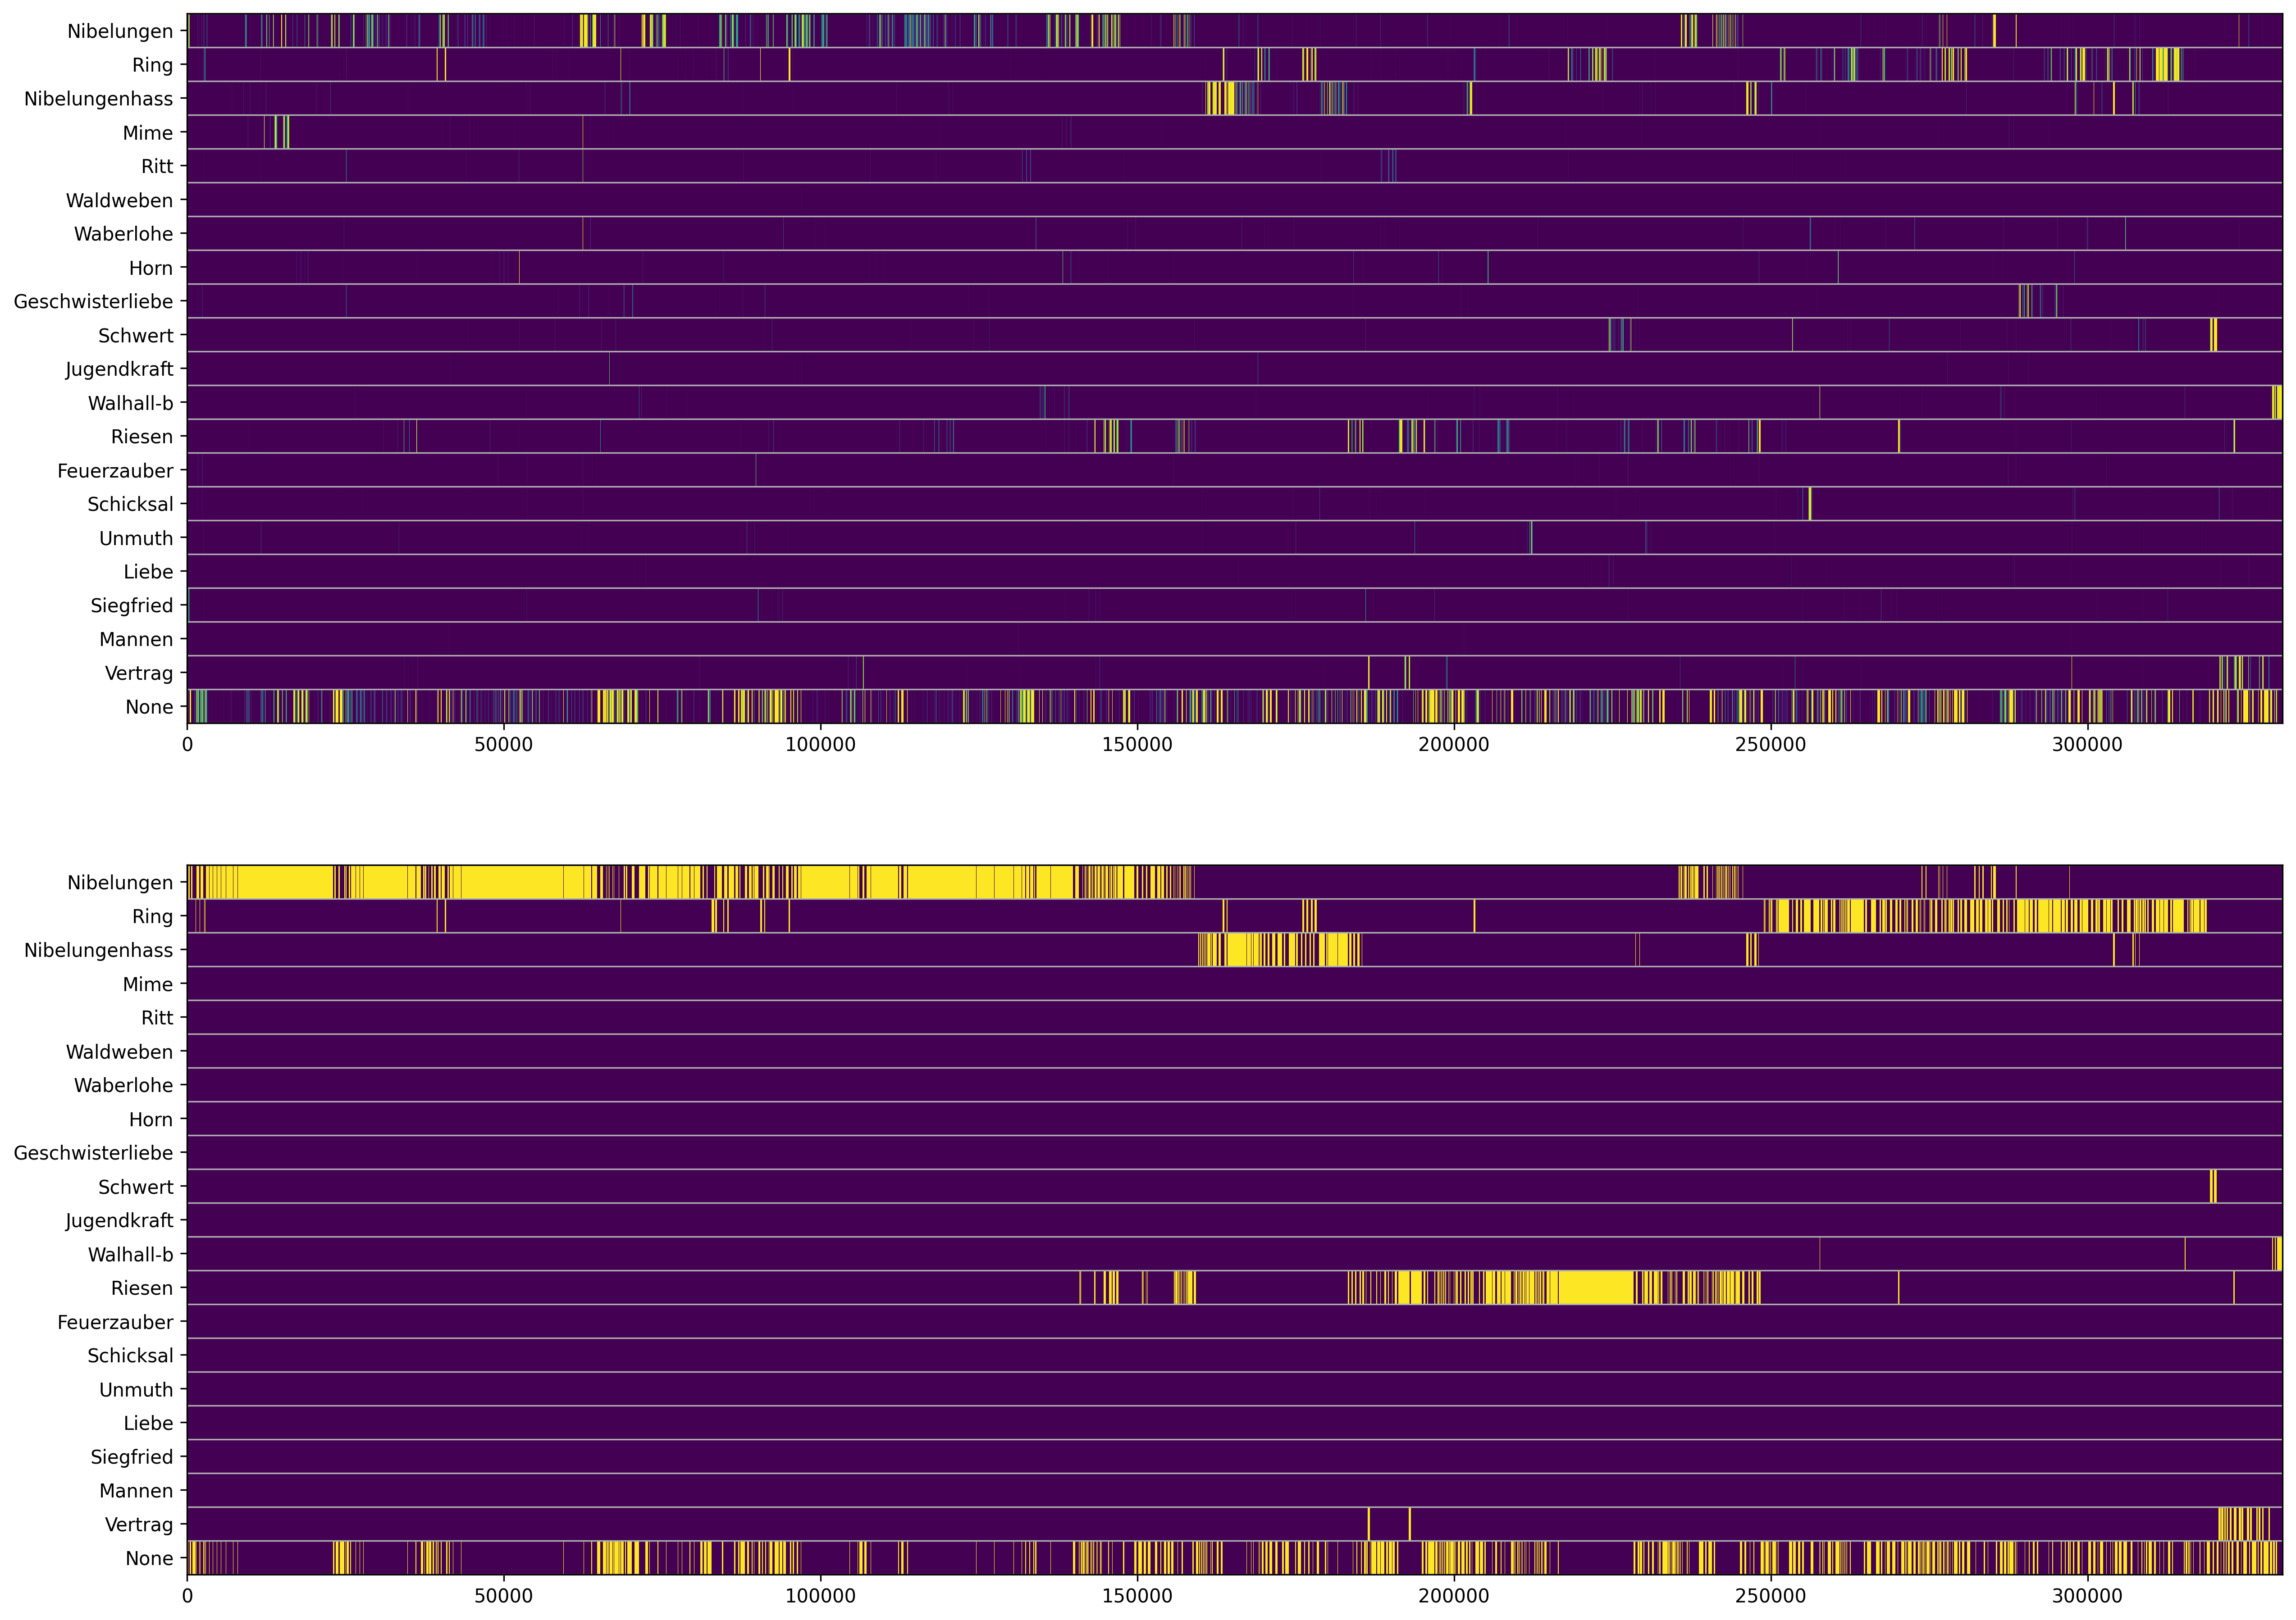

In [26]:
leitmotif_preds = torch.load("loader-pred.pt").detach().to("cpu")
leitmotif_gts = torch.load("loader-gt.pt").detach().to("cpu")

# pool = torch.nn.MaxPool1d(kernel_size=16, stride=1, padding=8)
# leitmotif_preds = pool(leitmotif_preds.T).T
# leitmotif_gts = pool(leitmotif_gts.T).T

fig, ax = plt.subplots(nrows=2, figsize=(20, 15), dpi=300)
im = ax[0].imshow(leitmotif_preds.T, origin="upper", aspect="auto", interpolation="none")
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[0].set_yticks(range(21))
ax[0].set_yticklabels(idx2motif + ["None"])
ax[0].tick_params(axis="y", which="minor", length=0)

im = ax[1].imshow(leitmotif_gts.T, origin="upper", aspect="auto", interpolation="none")
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[1].set_yticks(range(21))
ax[1].set_yticklabels(idx2motif + ["None"])
ax[1].tick_params(axis="y", which="minor", length=0)

ax[0].grid(axis="y", which="minor")
ax[1].grid(axis="y", which="minor")

plt.show()

### CNN

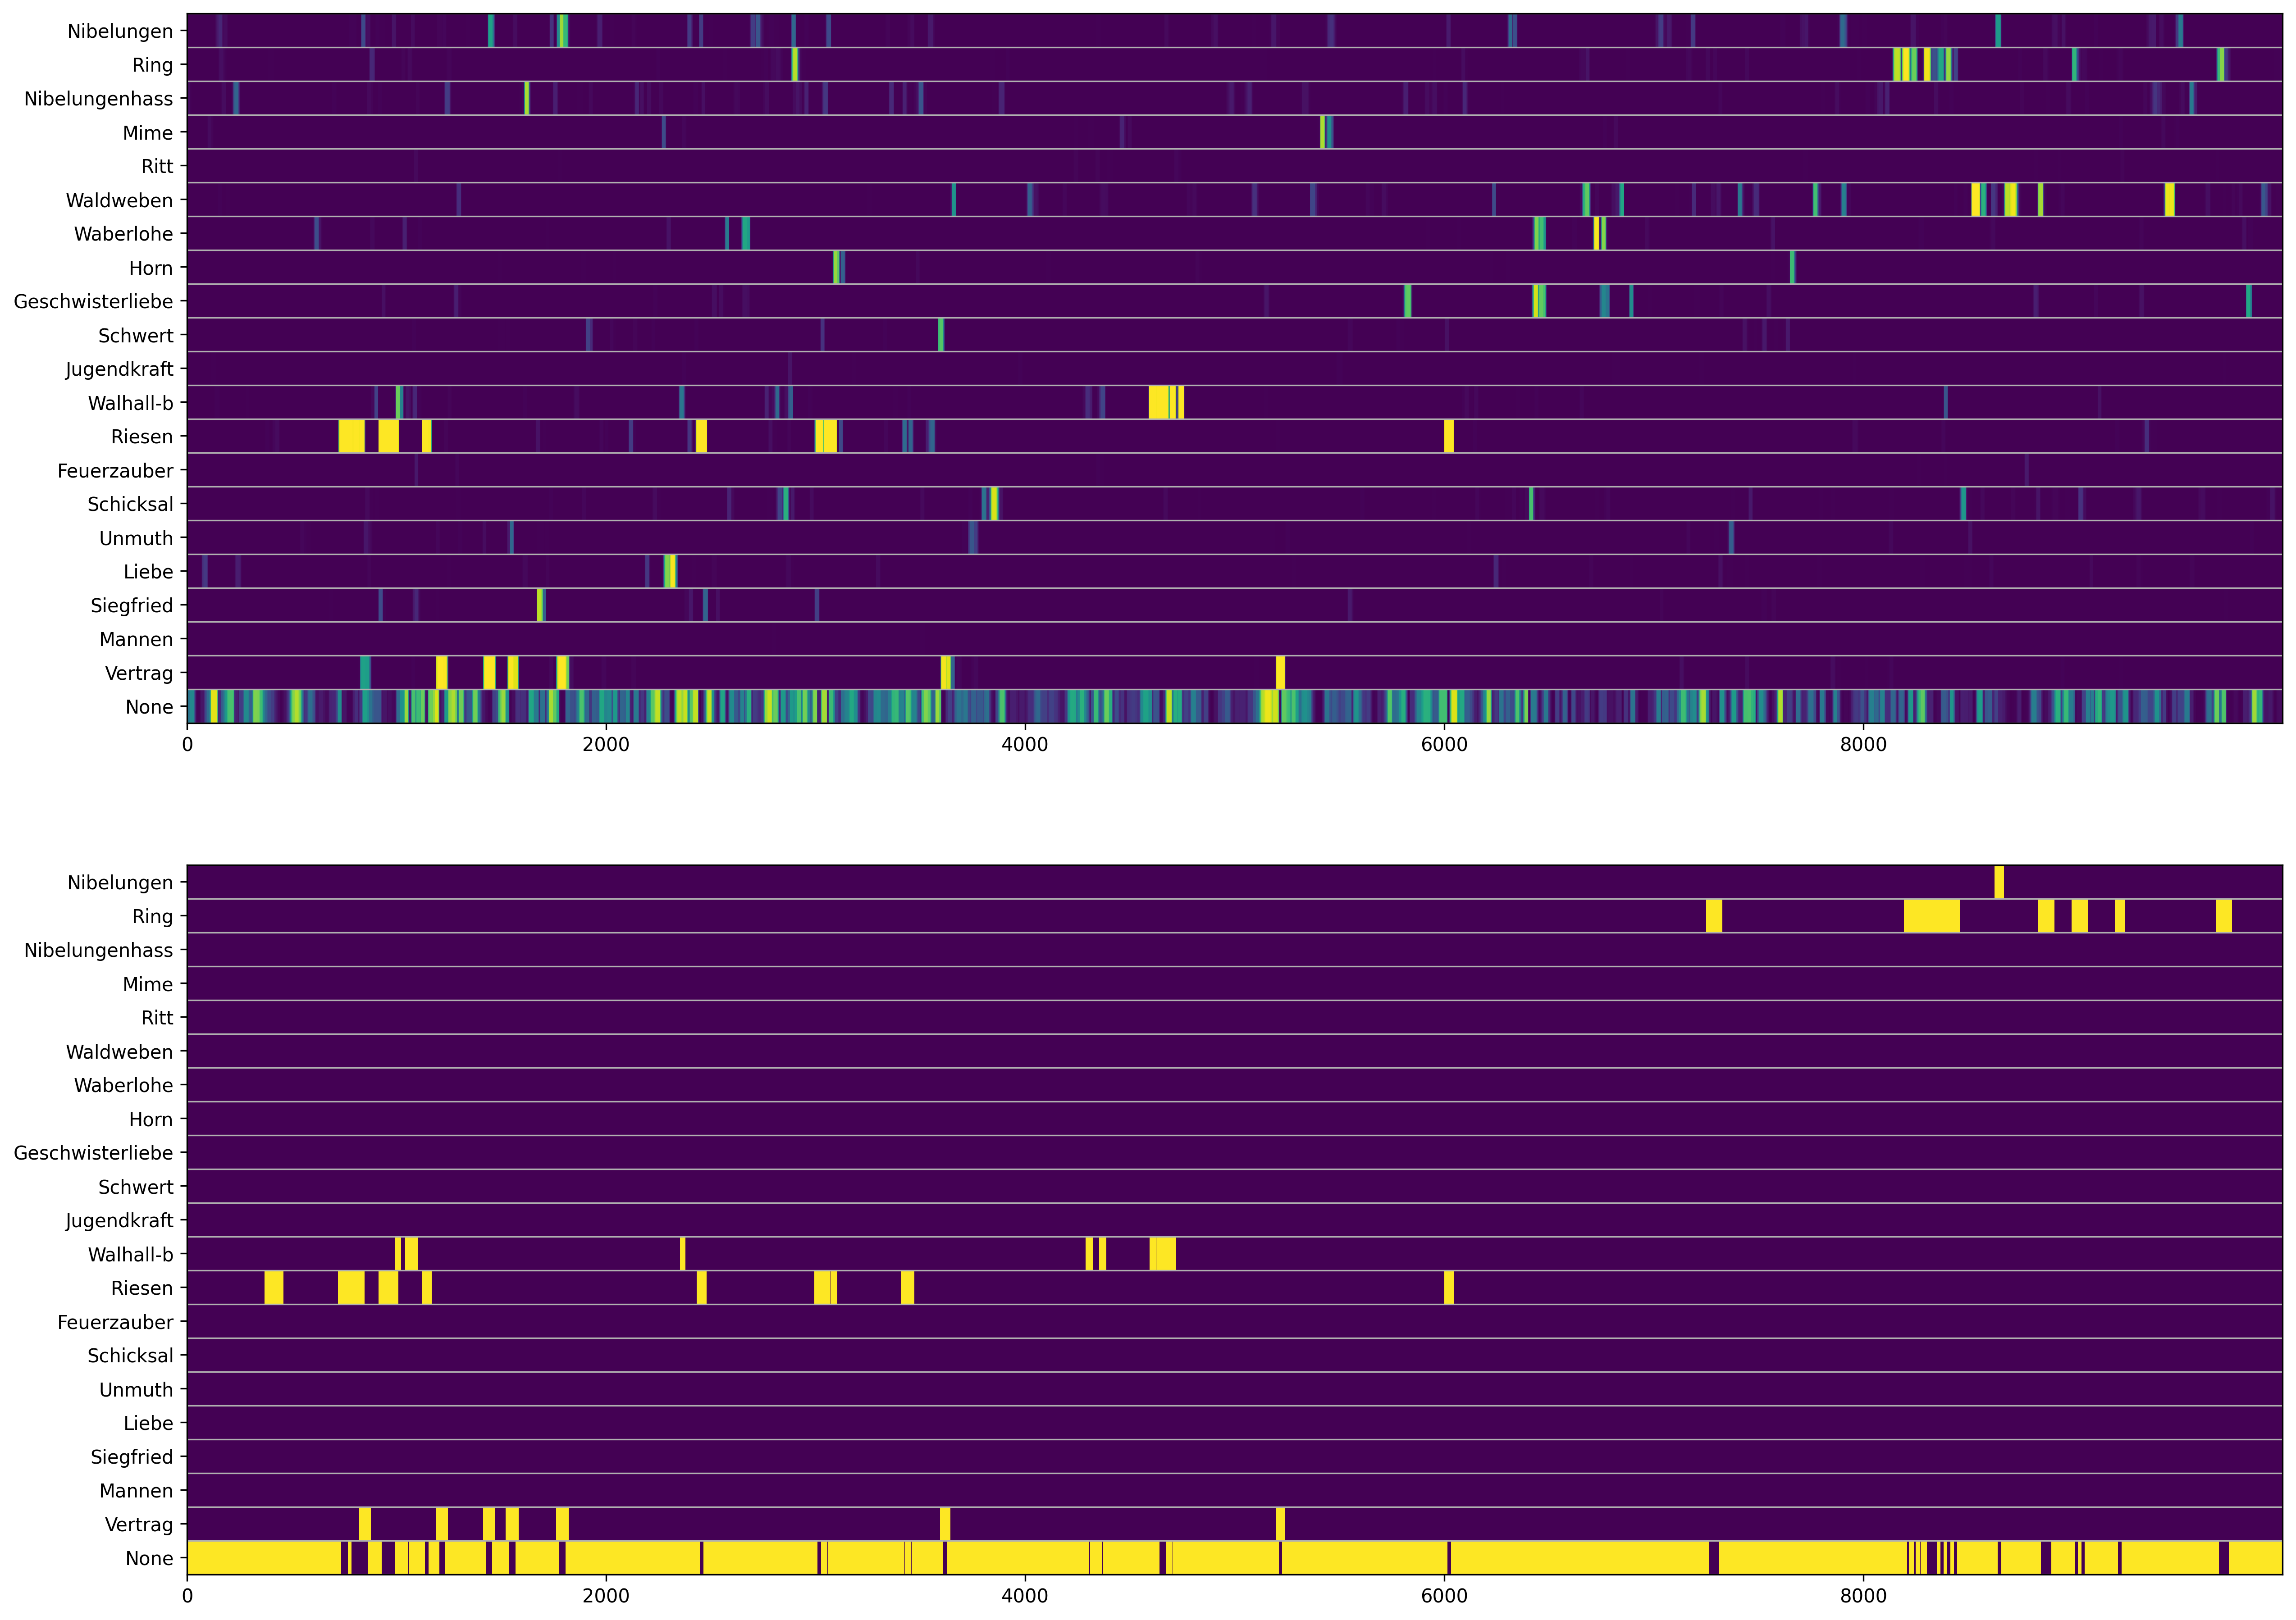

In [35]:
leitmotif_preds = torch.load("pred-cnn-max.pt").detach().to("cpu")[15000:25000, :]
leitmotif_gts = torch.load("gt-cnn-max.pt").detach().to("cpu")[15000:25000, :]

# pool = torch.nn.MaxPool1d(kernel_size=16, stride=1, padding=8)
# leitmotif_preds = pool(leitmotif_preds.T).T
# leitmotif_gts = pool(leitmotif_gts.T).T

fig, ax = plt.subplots(nrows=2, figsize=(20, 15), dpi=300)
im = ax[0].imshow(leitmotif_preds.T, origin="upper", aspect="auto", interpolation="none")
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[0].set_yticks(range(21))
ax[0].set_yticklabels(idx2motif + ["None"])
ax[0].tick_params(axis="y", which="minor", length=0)

im = ax[1].imshow(leitmotif_gts.T, origin="upper", aspect="auto", interpolation="none")
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[1].set_yticks(range(21))
ax[1].set_yticklabels(idx2motif + ["None"])
ax[1].tick_params(axis="y", which="minor", length=0)

ax[0].grid(axis="y", which="minor")
ax[1].grid(axis="y", which="minor")

plt.show()

In [15]:
cqt = torch.load("cqt_iter1282.pt").cpu()


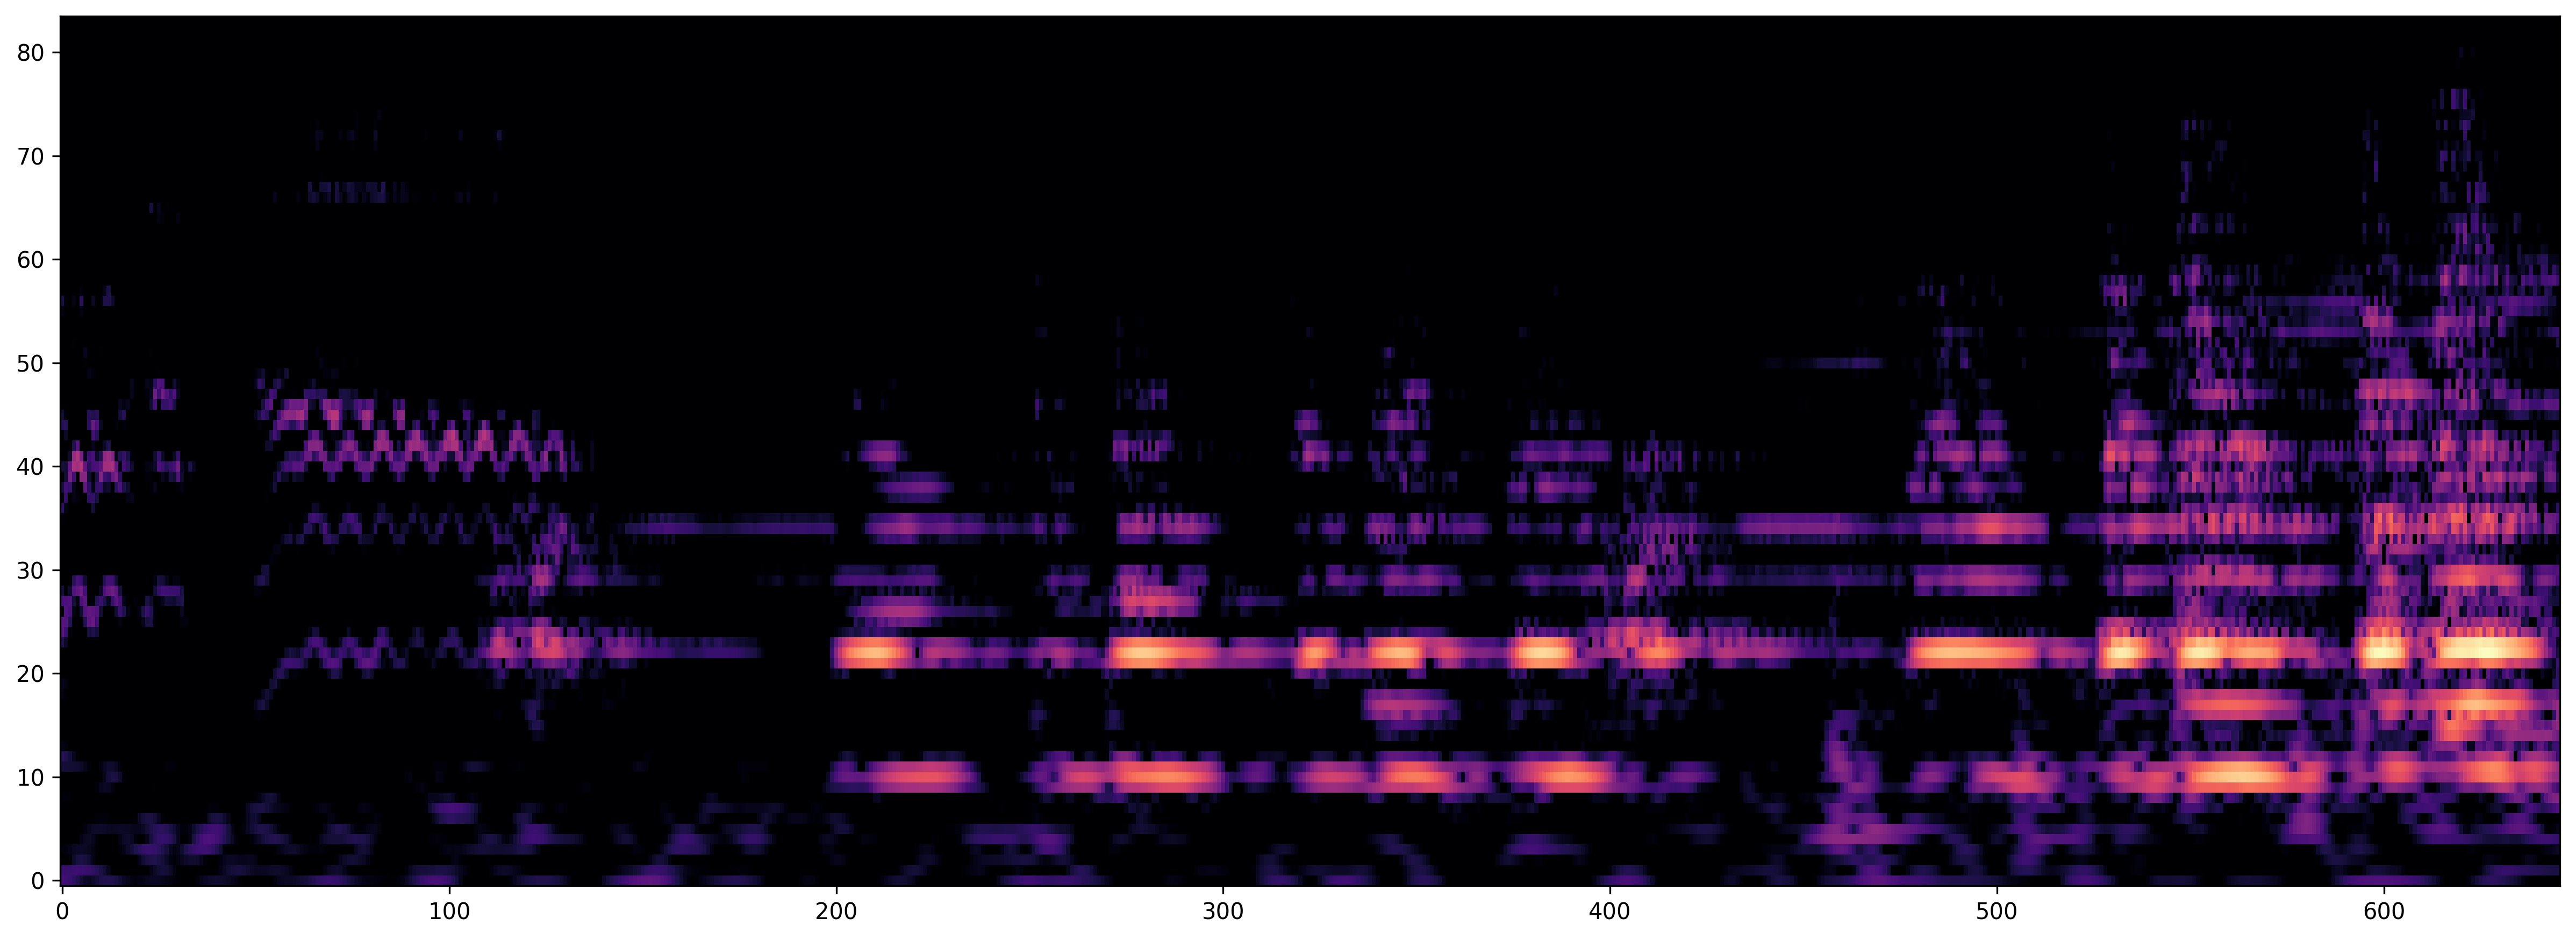

In [27]:
fig, ax = plt.subplots(figsize=(20, 7), dpi=300)
im = ax.imshow(cqt[8].T, origin="lower", aspect="auto", cmap="magma", norm="log", vmin=0.01)
plt.show()

In [3]:
from dataset import OTFDataset, Subset, collate_fn
DEV = "cuda" if torch.cuda.is_available() else "cpu"
base_set = OTFDataset(Path("data/wav-22050"), 
                        Path("data/LeitmotifOccurrencesInstances/Instances"),
                        Path("data/WagnerRing_Public/02_Annotations/ann_audio_singing"),
                        include_none_class = False,
                        split = "act",
                        mixup_prob = 0,
                        mixup_alpha = 0,
                        device = DEV)

Loading data...


  0%|          | 0/143 [00:00<?, ?it/s]

Sampling intervals...


  0%|          | 0/143 [00:00<?, ?it/s]

In [5]:
import constants as C
train_set = Subset(base_set, base_set.get_subset_idxs(acts=C.TRAIN_ACTS))
train_loader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=32, 
                                               shuffle=True,  
                                               collate_fn=collate_fn, 
                                               num_workers=4,
                                               pin_memory=True,
                                               pin_memory_device=DEV)

In [7]:
batch = next(iter(train_loader))

In [9]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"
wav, leitmotif_gt, singing_gt, version_gt = batch
wav = wav.to(DEV)
leitmotif_gt = leitmotif_gt.to(DEV)
singing_gt = singing_gt.to(DEV)
version_gt = version_gt.to(DEV)

In [ ]:
label_sum = leitmotif_gt.sum(dim=1)
label = label_sum.argmax(dim=-1)
is_non = label_sum.max(dim=-1).values == 0
random_label = torch.randint(0, leitmotif_gt.shape[-1], (sum(is_non),)).to(label.device)
label[is_non] = random_label
leitmotif_pred, singing_pred, version_pred = self.model(wav, label)
leitmotif_pred = leitmotif_pred[torch.arange(leitmotif_pred.shape[0]), :, label]
leitmotif_gt = leitmotif_gt[torch.arange(leitmotif_gt.shape[0]), :, label]

In [18]:
label_sum = leitmotif_gt.sum(dim=1)
label = label_sum.argmax(dim=-1)
is_non = label_sum.max(dim=-1).values == 0
random_label = torch.randint(0, leitmotif_gt.shape[-1], (sum(is_non),)).to(label.device)

In [19]:
random_label

tensor([ 9, 12, 11,  0,  3,  7,  6,  9,  6,  6, 12,  8,  5,  3,  6],
       device='cuda:0')

In [15]:
is_non

tensor([ True, False,  True, False, False, False, False,  True,  True, False,
        False, False,  True, False, False,  True,  True, False, False,  True,
         True,  True,  True, False, False, False, False, False,  True,  True,
         True,  True], device='cuda:0')

In [2]:
gt = torch.load('BBox_Bh_D-1_gt.pt')
pred = torch.load('BBox_Bh_D-1_pred.pt')
pred_medfilt = torch.load('BBox_Bh_D-1_pred_medfilt.pt')
gt_maxed = torch.load('BBox_Bh_D-1_gt_maxed.pt')
pred_maxed = torch.load('BBox_Bh_D-1_pred_maxed.pt')

In [16]:
pred_maxed.shape

torch.Size([201126, 13])

In [4]:
gt.shape

torch.Size([201126, 13])

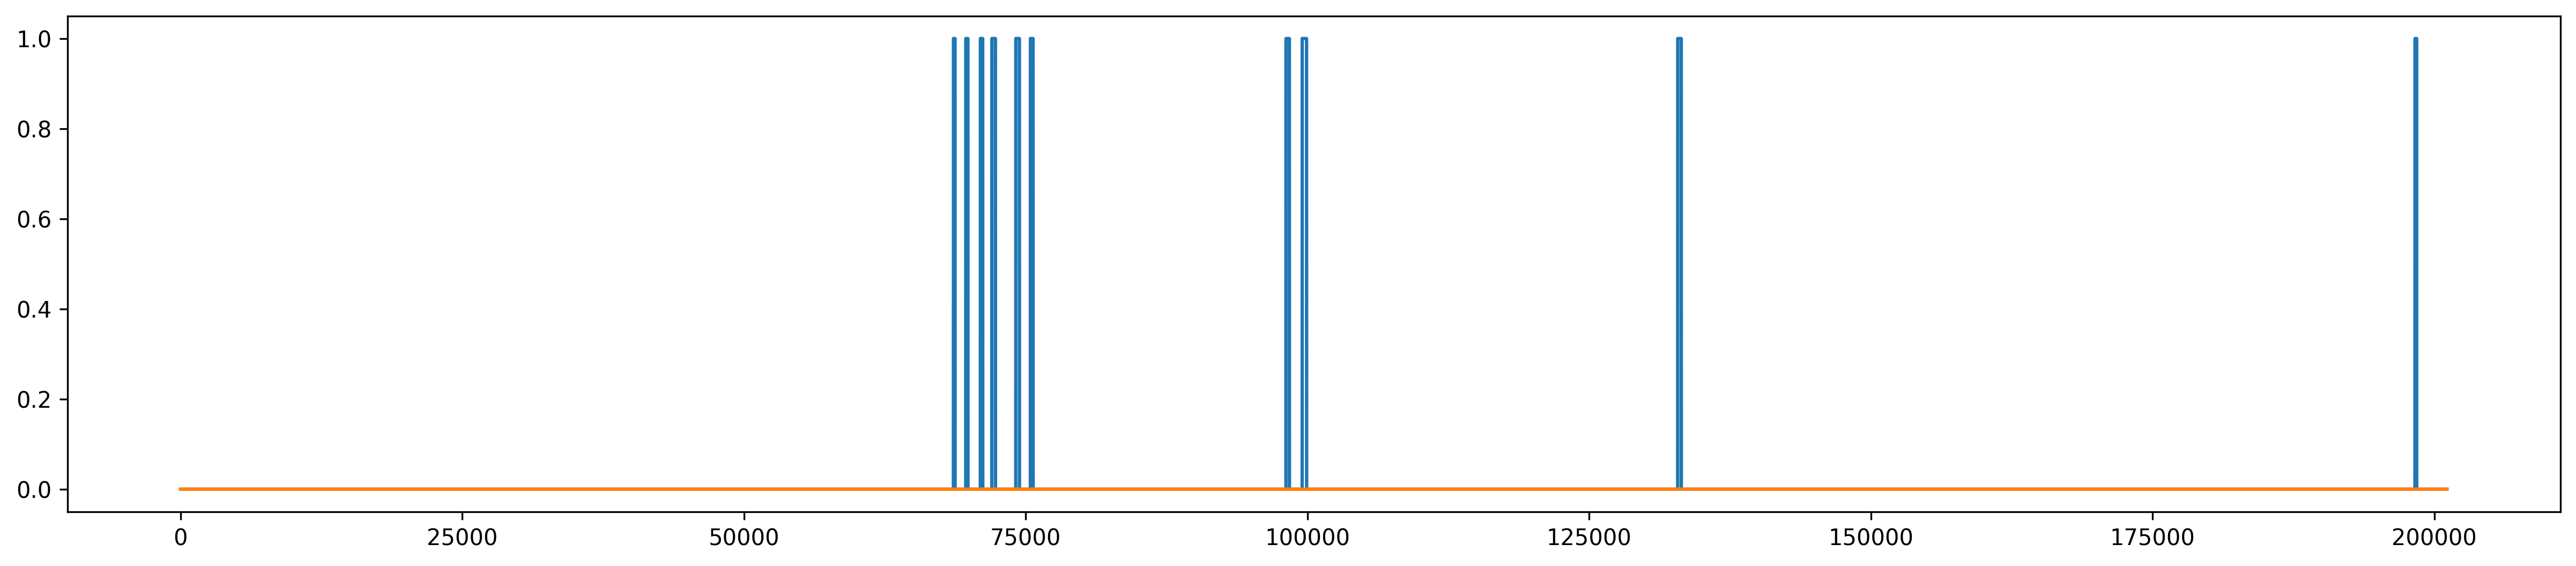

In [22]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
ax.plot(gt[:, 12])
# ax.fill_between([x for x in range(11500)], gt, alpha=0.3)
ax.plot(pred[:, 12])
# ax.plot(pred_medfilt)

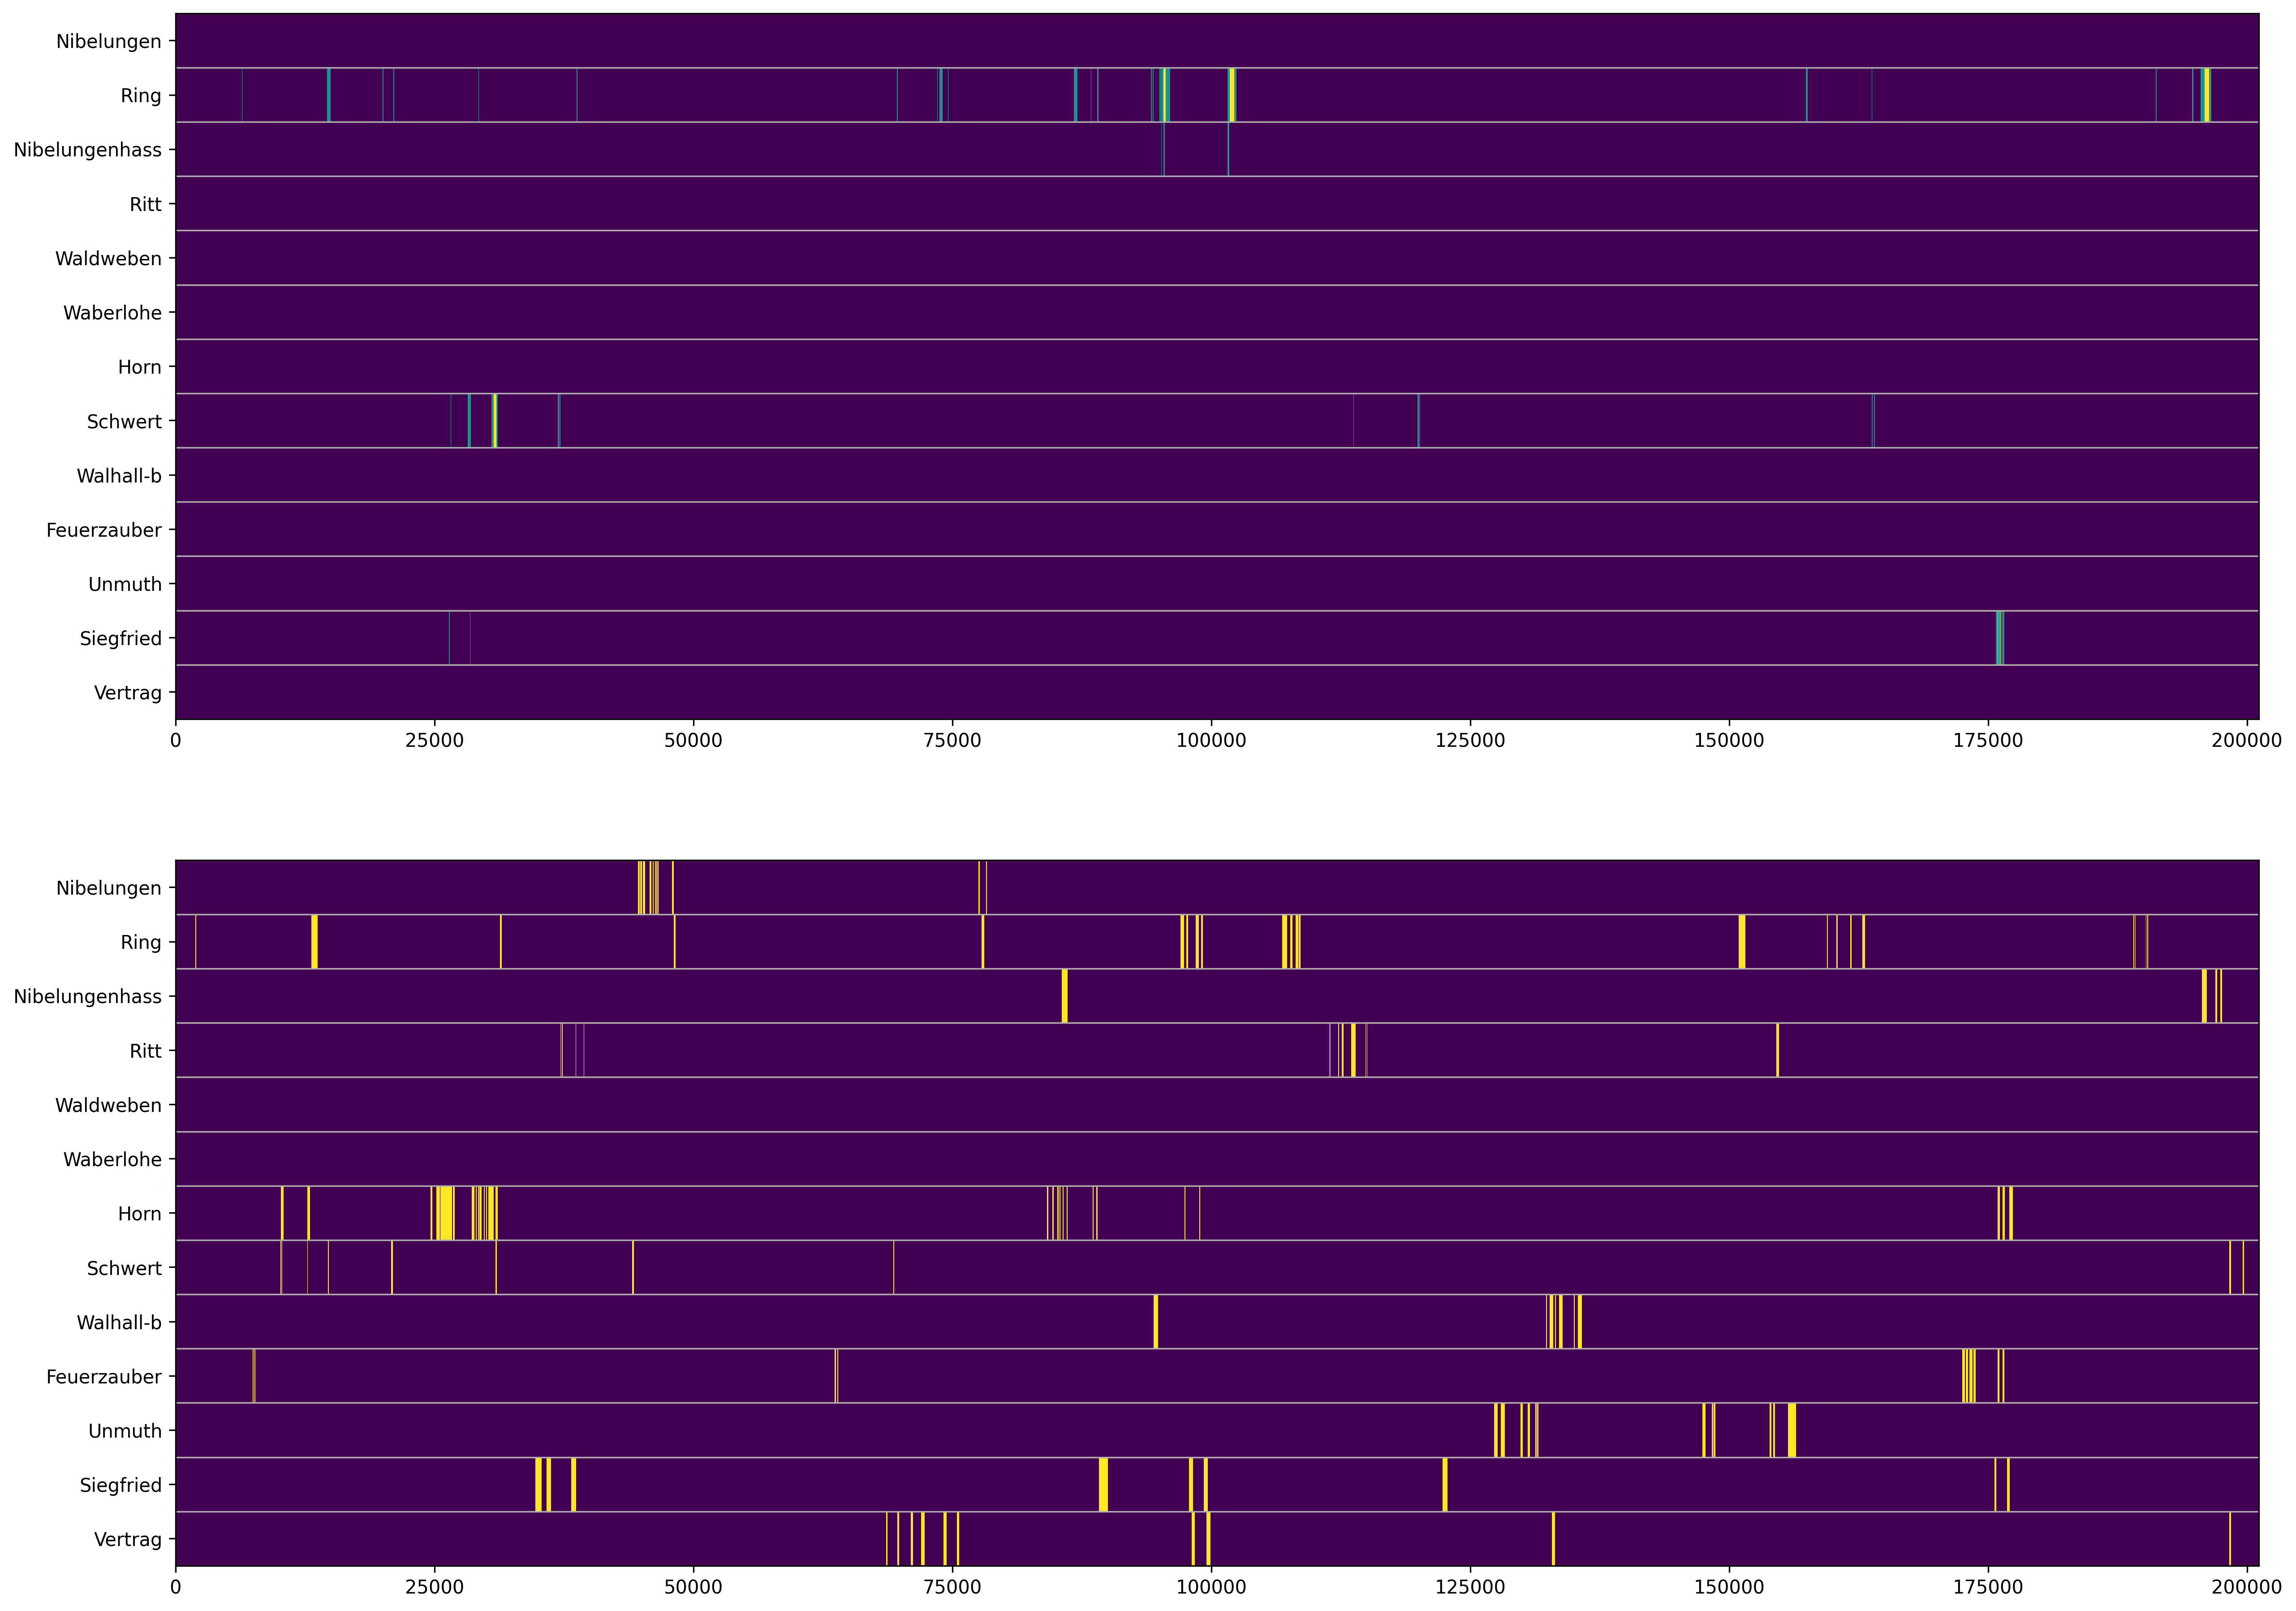

In [23]:
# pool = torch.nn.MaxPool1d(kernel_size=16, stride=1, padding=8)
# leitmotif_preds = pool(leitmotif_preds.T).T
# leitmotif_gts = pool(leitmotif_gts.T).T

fig, ax = plt.subplots(nrows=2, figsize=(20, 15), dpi=300)
im = ax[0].imshow(pred.T, origin="upper", aspect="auto", interpolation="none")
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[0].set_yticks(range(13))
ax[0].set_yticklabels(idx2motif)
ax[0].tick_params(axis="y", which="minor", length=0)

im = ax[1].imshow(gt.T, origin="upper", aspect="auto", interpolation="none")
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax[1].set_yticks(range(13))
ax[1].set_yticklabels(idx2motif)
ax[1].tick_params(axis="y", which="minor", length=0)

ax[0].grid(axis="y", which="minor")
ax[1].grid(axis="y", which="minor")

plt.show()